## 1. Data and Preprocessing 

In [1]:
#Libraries required for data scraping, cleaning and preprocessing
#pip install google
from googlesearch import search
import pandas as pd
import requests
from bs4 import BeautifulSoup
from lxml import html
import time
import random
import numpy as np
import spacy
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from gensim.models.phrases import Phrases

C:\Users\fabio\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


#### Dataset description
The dataset that I have found contains data related to books. In particular, for each book, the entire corpus, the title and the genres identified from Goodreads users are reported. The dataset comes from Project Gutenberg and I have downloaded it from: https://www.kaggle.com/michaelrussell4/10000-books-and-their-genres-standardized. To complete this dataset, I will now scrape the author's name and the year of publication.

#### Code used to scrape author and year of publication
Note that the books that had no author nor year of publication were dropped.

In [ ]:
#Beware: the code took 2 days to fully scrape the required information
# curr=0
# df1=pd.read_csv('original_data.csv')
# df1=pd.DataFrame(title, columns=['Title'])
# title=df['title'].tolist()
# year_public=[]
# author_name=[]
# df1.loc[:,'author'] = pd.Series([author_name])
# df1.loc[:,'year'] = pd.Series([year_public])
# while curr < len(df1['Title']):
#     query = str(df1['Title'][curr]) + ' goodreads'
#     l=[]
#     try:
#         for j in search(query, tld="com", num=10, stop=10, pause=2):
#             l.append(j)
#             break
#         try:
#             page=requests.get(l[0])
#             soup=BeautifulSoup(page.content, 'html.parser')
#             try:
#                 author_box = soup.find("div", class_="authorName__container")
#                 author_link = author_box.find("a")
#                 author_text = author_link.get_text()
#             except:
#                 author_text='NaN'
#             df1['author'][curr]=author_text
#             try:
#                 year_box = soup.find("div", class_="uitext darkGreyText")
#                 t=year_box.get_text()
#                 t=t.replace('\n', '')
#                 s=t[t.find("(")+1:t.find(")")]
#                 if 'published' not in s.lower():
#                     b=t.split()
#                     b.index('Published')
#                     year=b[6]
#                 else:
#                     t=s.split()
#                     year=t[-1]
#             except:
#                 year='NaN'
#             df1['year'][curr]=year
#             curr+=1
#             df1.to_csv('Definite_data.csv')
#             y=random.random()+2
#             time.sleep(y)
#         except:
#             y=random.random()*12+2
#             time.sleep(y)
#     except:
#         y=random.random()*12+2
#         time.sleep(y)

In [3]:
df=pd.read_csv('Definite_data.csv')

Additionally, the original, the text of each book begins with Produced by ..., which features the names of individuals that have worked on proofreading/creating the digital version of the book. Also, each book ends with 'End of Project Gutenberg ...'. Since those information are not related to the book corpus, I have decided to drop them with the following code: 

In [4]:
#Code to transform the text of the data
for j in range(len(df['text'])):
    l=df.loc[j]['text'].split()
    start=None
    end=None
    for i in range(len(l)-1, 1, -1):
        if l[i]=='End':
            end=i
            break
    for i in range(8, len(l)):
        if l[i].isupper():
            start=i
            break
    text=l[start:end]
    df.loc[j, 'text']=' '.join(text)

In [5]:
df.head()

Unnamed: 0                        Title                author  year  \
0           0              apocolocyntosis                Seneca    54   
1           1  the house on the borderland  William Hope Hodgson  1908   
2           2                 the warriors            Sol Yurick  1965   
3           3         a voyage to the moon         George Tucker  1827   
4           4                 la fiammetta    Giovanni Boccaccio  1343   

                                                text  \
0  SENECA APOCOLOCYNTOSIS WITH AN ENGLISH TRANSLA...   
1  THE HOUSE ON THE BORDERLAND William Hope Hodgs...   
2  THE WARRIORS BY ANNA ROBERTSON BROWN LINDSAY P...   
3  L. Shell and PG Distributed Proofreaders A VOY...   
4  LA FIAMMETTA BY GIOVANNI BOCCACCIO TRANSLATED ...   

                                              genres  
0  ['historical', '[', ']', 'classics', 'non-fict...  
1  ['[', ']', 'classics', 'fantasy', '20th-centur...  
2  ['historical', '[', ']', 'historical-fiction',...  
3                         ['20th-century', '[', ']']  
4  ['historical', '[', ']', 'classics', 'non-fict...

#### Preprocessing

In [7]:
print(f'Before preprocessing:')
print(f'The average book in the dataset is composed by : {int(np.mean(df.text.apply(len))):,} words')
print(f'The total number of tokens in the dataset: {np.sum(df.text.apply(len)):,} words')
s=set()
for i in range(len(df.text)):
    for j in df.text[i].split():
        s.add(j)
print(f'The unique number of tokens in the dataset: {len(s):,} words')
print(f'The Dataset is composed by {len(df.text):,} books')
print(f'The number of authors present in the dataset is: {len(set(df.author))}')

Before preprocessing:
The average book in the dataset is composed by : 332,964 words
The total number of tokens in the dataset: 1,902,223,468 words
The unique number of tokens in the dataset: 4,563,055 words
The Dataset is composed by 5,713 books
The number of authors present in the dataset is: 3097


In [2]:
import sys 
output_stream = sys.stdout
#This will be used to monitor the progression of the code below

In [24]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat', 'tokenizer']) 
#I am keeping only the lemmatizer and the pos. This should speed up the process.

def text_cleaning(text):
     return ' '.join([token.lemma_ for token in nlp(text[:len(text)//2]) if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'} and
             token not in set(stopwords.words('english'))]) 
    #In this way I am keeping only content words and removing any stopword that could be left.
    #Due to a memory error I had to run the code iteratively on the dataframe df1 (smaller dataframe in terms of size) and save
    #every 5 iterations so as to not lose the preprocessing being made.
    #Also, considering the entire book is an extremely costly procedure. The code is able to preprocess 78 books per hour
    #which would imply a runtime of 73.2 hours. 
    #Therefore, I will consider the first half of each book.
    
df1=pd.DataFrame(df['Title'], columns=['Title'])
    
for j in range(len(df.text)):
    df1.loc[j, 'text_cleaned']=text_cleaning(df.text[j])
    output_stream.write('Cleaning %s\r' % j)
    output_stream.flush()
    if j%5==0:
        df1.to_csv('Cleaned_text.csv')
df1.to_csv('Cleaned_text.csv')

<ipython-input-24-02ac6799f73b>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df1.loc[:,'cleaned_text'] = pd.Series([])


In [44]:
#Substituting all numbers with 0s. This should lead to greater comparability of text between books as numbers per se will not 
#have special meaning in the corpus.
import re
for j in range(len(df1.text_cleaned)):
    tx = re.sub(r'\d', '0', df1['text_cleaned'][j])
    df1.loc[j,'text_clean_num'] = tx.lower()
    output_stream.write('Books changed %s\r' % j)
    output_stream.flush()

#Joining collocations. Once again, this should improve the comparability of books as words that form one construct will be joined
#together.
for j in range(len(df1.text_clean_num)):
    words = df1.loc[j, 'text_clean_num'].split()
    phrases = Phrases(words)
    collocations = phrases[words]
    df1.loc[j, 'text_colloc']=' '.join(collocations)
    output_stream.write('Collocation %s\r' % j)
    output_stream.flush()

In [69]:
#Merging the original data with the the cleaned text.
df=df.drop('text', axis=1)
df2=df1[['text_colloc', 'Title']]
data=pd.merge(df, df2, on='Title')

#fixing the genre (this function was provided together with the dataset).
def reformatGenres(genres):
    l_genres = list(filter(None, re.split(r"[\{\}\,\s\']", genres)))
    # Combine history and historical tags since they refer to the same genre
    r_genres = list({e if e!='history' else 'historical' for e in l_genres})
    return r_genres
data.genres = data.loc[:, 'genres'].apply(reformatGenres)

In [40]:
#Fixing the parentheses in genre
for j in range(len(data.genres)):
    a=''
    for h in data.loc[j, 'genres']:
        a+=h+' '
    data.loc[j, 'genres']=a
    data.loc[j, 'genres']=data.loc[j, 'genres'].replace(']','')
    data.loc[j, 'genres']=data.loc[j, 'genres'].replace('[','')
    
#Reformatting genre in a more clear manner
for j in range(len(data.genres)):    
    l=data.genres[j].replace('\'', '').split(',')
    g=[]
    for i in l:
        if len(i)>1:
            g.append(i)
    data.loc[j, 'genres']=' '.join(g)
    data.loc[j, 'genres']=data.loc[j, 'genres'].strip()

#Creating dummies for the different genres
data['fiction']=0
for i in range(len(data.genres)):
    if 'fiction' in data.genres[i]:
        data.loc[i, 'fiction']=1
        
data['classics']=0
for i in range(len(data.genres)):
    if 'classics' in data.genres[i]:
        data.loc[i, 'classics']=1
        
data['historical']=0
for i in range(len(data.genres)):
    if 'historical' in data.genres[i]:
        data.loc[i, 'historical']=1
        
data['20th-century']=0
for i in range(len(data.genres)):
    if '20th-century' in data.genres[i]:
        data.loc[i, '20th-century']=1
        
data['non-fiction']=0
for i in range(len(data.genres)):
    if 'non-fiction' in data.genres[i]:
        data.loc[i, 'non-fiction']=1

data['historical-fiction']=0
for i in range(len(data.genres)):
    if 'historical-fiction' in data.genres[i]:
        data.loc[i, 'historical-fiction']=1

data['literature']=0
for i in range(len(data.genres)):
    if 'literature' in data.genres[i]:
        data.loc[i, 'literature']=1
        
data['romance']=0
for i in range(len(data.genres)):
    if 'romance' in data.genres[i]:
        data.loc[i, 'romance']=1

data['fantasy']=0
for i in range(len(data.genres)):
    if 'fantasy' in data.genres[i]:
        data.loc[i, 'fantasy']=1
        
data['adventure']=0
for i in range(len(data.genres)):
    if 'adventure' in data.genres[i]:
        data.loc[i, 'adventure']=1
        
data.to_csv('final_data.csv')
#This represents the Final dataset. I am including only the text with the joined collocations as working on a smaller dataset in terms of overall size
#is more efficient

In [43]:
data.head()

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0           0             0               0                 0   
1           1             1               1                 1   
2           2             2               2                 2   
3           3             3               3                 3   
4           4             4               4                 4   

   Unnamed: 0.1.1.1.1                        Title                author  \
0                   0              apocolocyntosis                Seneca   
1                   1  the house on the borderland  William Hope Hodgson   
2                   2                 the warriors            Sol Yurick   
3                   3         a voyage to the moon         George Tucker   
4                   4                 la fiammetta    Giovanni Boccaccio   

   year                                             genres  \
0    54  historical  classics  non-fiction  literature ...   
1  1908   classics  fantasy  20th-century  literature  ...   
2  1965  historical  historical-fiction  classics  fant...   
3  1827                                       20th-century   
4  1343  historical  classics  non-fiction  20th-centur...   

                                         text_colloc  ...  classics  \
0  seneca apocolocyntosis english translation w.h...  ...         1   
1  on borderland william hope hodgson _ manuscrip...  ...         1   
2  anna robertson brown lindsay ph.d. author be w...  ...         1   
3  l. shell pg distribute proofreaders voyage moo...  ...         0   
4  la fiammetta giovanni boccaccio translate jame...  ...         1   

   historical  20th-century  non-fiction  historical-fiction  literature  \
0           1             0            1                   0           1   
1           0             1            0                   0           1   
2           1             1            1                   1           1   
3           0             1            0                   0           0   
4           1             1            1                   0           1   

   romance  fantasy  adventure           color  
0        0        0          0            gray  
1        0        1          0            gray  
2        0        1          0            gray  
3        0        0          0  darkolivegreen  
4        0        0          0            gray  

[5 rows x 21 columns]

###### Description:
My preprocessing consists in: eliminating all the punctuation, keeping only the dictionary entry for each content word and replacing any possible number present with as many 0s as there are digits. Such preprocessing is required to increase the comparability of content between the different books. In fact, later, when models such as Topic Modelling, Doc2Vec, etc. will be applied, the text being analyzed will contain the actual content of each book. In this regard, keeping the dictionary entry for each content word ensures a reduction in variability of words that have similar meanings. The choice of keeping only content words is motivated by the fact that multiple words are present in every text but they carry no meaning by themselves (i.e. articles, etc.). I have also decided to substitute the digits that could be present in each book with as many 0s as there are digits in the number; this is motivated by the fact that digits do not, by themselves, carry meaning in this specific application. The final preprocessing step that I have decided to apply relates to collocations. In particular, I have decided to join collocations to ensure that composite words will be counted as one. Once again, this should improve the comparability of the corpus of different books.

Finally, for the language model that will later be executed, I have used the original text for greater accuracy. In fact, the presence of stopwords and punctuation will be useful when new text will be fed into the model to obtain predictions.

#### Summary Statistics

After preprocessing:
The average book in the dataset is composed by : 102,015 words
The total number of tokens in the dataset: 582,815,934 words
The unique number of tokens in the dataset: 659,739 words
The unique number of tokens in the dataset: 5713 words
The final dataset is composed by: 5,713 books
The number of authors present in the dataset is: 3097


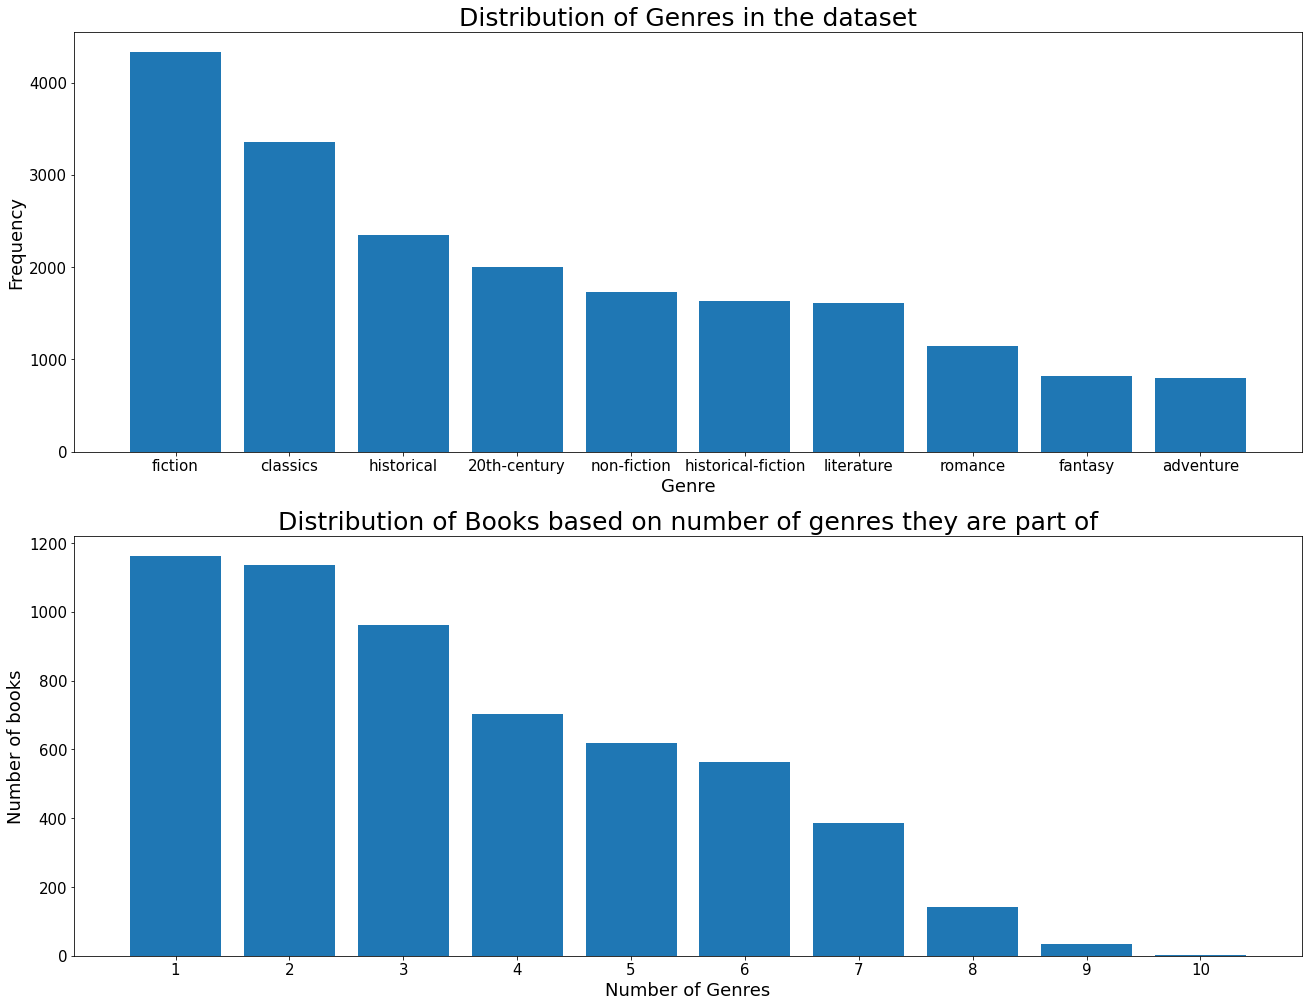

In [9]:
print(f'After preprocessing:')
print(f'The average book in the dataset is composed by : {int(np.mean(data.text_colloc.apply(len))):,} words')
print(f'The total number of tokens in the dataset: {np.sum(data.text_colloc.apply(len)):,} words')
s=set()
for i in range(len(data.text_colloc)):
    for j in data.text_colloc[i].split():
        s.add(j)
print(f'The unique number of tokens in the dataset: {len(s):,} words')
print(f'The unique number of tokens in the dataset: {data.text_colloc.str.lower().nunique()} words')
print(f'The final dataset is composed by: {len(data.text_colloc):,} books')
print(f'The number of authors present in the dataset is: {len(set(data.author))}')
fig, axs = plt.subplots(nrows=2, figsize=(22,17))

ax=axs[0]
ax.set_title('Distribution of Genres in the dataset', fontsize=25)
genres = [i for h in data.genres for i in h.split('  ')]
genres_counts = pd.Series(genres).value_counts()
genres=pd.DataFrame(genres_counts).rename({0:'Count'}, axis=1).reset_index().rename({'index':'Genre'}, axis=1)
ax.bar(genres['Genre'], genres['Count'])
ax.set_xlabel('Genre', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xticks(genres['Genre'])
ax.tick_params(axis='both', which='major', labelsize=15)

ax=axs[1]
ax.set_title('Distribution of Books based on number of genres they are part of', fontsize=25)
from collections import defaultdict
d=defaultdict(int)
for i in range(len(data.genres)):
    a=len(data.genres[i].split('  '))
    d[a]+=1
k=[i for i in d.keys()]
v=[i for i in d.values()]
ax.bar(k, v)
ax.set_xlabel('Number of Genres', fontsize=18)
ax.set_ylabel('Number of books', fontsize=18)
ax.set_xticks(k)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

### Question being investigated:
The goal of the analysis is that of assessing books' similarity. In particular, given the books' corpus, I would like to understand similarities and dissimilarities that are present between books of different genre. The ultimate goal is that of understanding whether the book genre provided by goodreads users is a relevant feauter for classifying the different books. 

Additionally, this notebook aims at setting the foundations for: a book recommender system and a book genre detector. 

# TF-IDF
TF-IDF analysis, applied to the book context, presupposes looking at the TF-IDF representation of each word in a document and observing a document as a vector of TF-IDF representation of its words. Then, it is possible to compute the cosine siilarity and assess how similar the two documents really are. Moreover, through TF-IDF, it is possible to observe the presence of clusters and assess whether books of the same genre form clusters together.

In [2]:
data=pd.read_csv('final_data.csv')
data.head(2)

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0           0             0               0                 0   
1           1             1               1                 1   

                         Title                author  year  \
0              apocolocyntosis                Seneca    54   
1  the house on the borderland  William Hope Hodgson  1908   

                                              genres  \
0  historical  classics  non-fiction  literature ...   
1   classics  fantasy  20th-century  literature  ...   

                                         text_colloc  fiction  classics  \
0  seneca apocolocyntosis english translation w.h...        1         1   
1  on borderland william hope hodgson _ manuscrip...        1         1   

   historical  20th-century  non-fiction  historical-fiction  literature  \
0           1             0            1                   0           1   
1           0             1            0                   0           1   

   romance  fantasy  adventure  
0        0        0          0  
1        0        1          0

In [4]:
corpus=data.text_colloc.to_list() #I have now a list, where each entry is the corpus of a book 

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf_vectorizer=TfidfVectorizer(min_df=0.01, #I am considering words that appear at least in 1% of the books
                                 max_df=0.60) #I am considering words that appear at most in 60% of the books
#Multiple parameters were tried and this pair provides a great equilibrium between being representative for each book (consider that the average length of
#a book is of 102,000 words) and not encounting a memory error.
#Also, the n-gram range cannot be specified. I have tried multiple runs with different parameters (each lasting around 4 hours), and, 
#in the end, I always got a memory error.
#Finally, I have noticed that setting a lower maximum number of features (i.e. 1000 words) leads to more clustered data. This, however, I believe limits too
#much the representation of each book. 

vectors = tfidf_vectorizer.fit_transform(corpus)
feature_names=tfidf_vectorizer.get_feature_names()

similarities=np.dot(vectors,vectors.T).toarray() #represents the cosine similarity between books

In [41]:
vectors.shape

(5713, 24016)

Given that each row is a book vector, I can then represent the documents in a graph by first reducing the dimensionality of each vector. An important thing to consider is that through the TF-IDF representation, I am not comparing documents in terms of their semantics, but rather, I am comparing them in terms of TF-IDF score for each term.

In [37]:
from sklearn.manifold import TSNE
tsne=TSNE(2, metric = 'cosine', random_state=2).fit_transform(vectors)
tsne.shape
#I have compressed the information that is presented by the tf-idf into 2 dimensions

C:\Users\fabio\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


(5713, 2)

In [46]:
#Coloring. I am assigning colos to books that are part only of one specific genre. The rationale is that those books should be the ones that are more far 
#apart from one another compared to books that are part of multiple genres.
data['color']='gray' #assigning color gray to all books
d={'fiction':'red', 'non_fiction': 'aqua', 'classics': 'orange', 'historical':'yellow', '20th-century':'darkolivegreen',
                  'historical-fiction':'lime', 'literature':'dodgerblue', 'romance':'navy', 
                  'fantasy':'magenta', 'adventure':'brown', 'more than 1 genre':'gray'} #dictionary of colors for the individual genres
for i in range(len(data.genres)):
    if sum((data['fiction'][i], data['non-fiction'][i], data['classics'][i], data['historical'][i], data['20th-century'][i],
           data['historical-fiction'][i], data['literature'][i], data['romance'][i], data['fantasy'][i], data['adventure'][i]))==1:
        data.loc[i, 'color']=d[data.genres[i].strip()] 
colors_l=data.color.tolist()

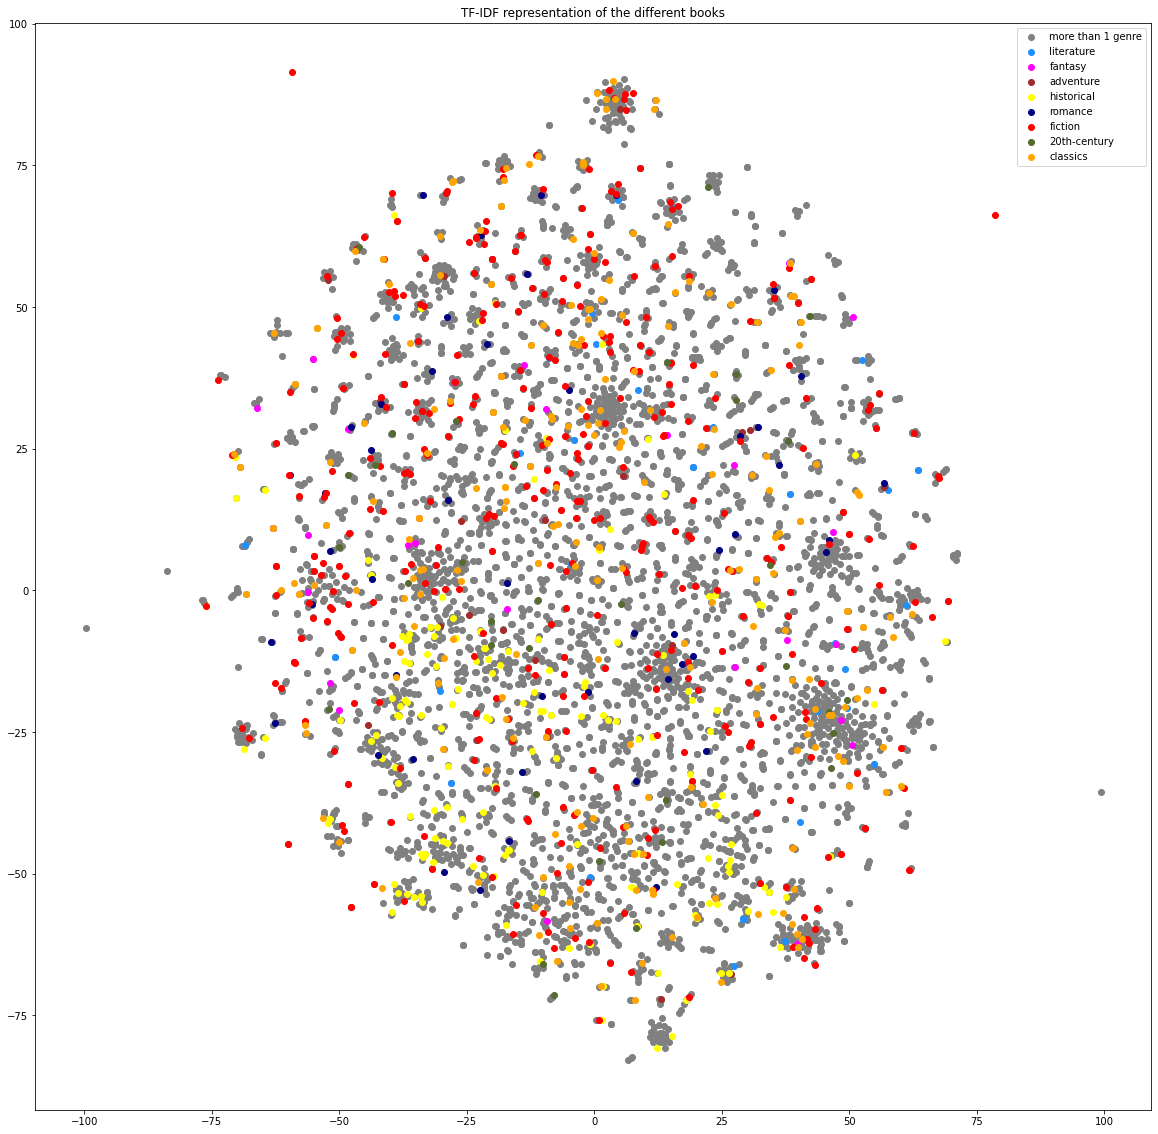

In [48]:
df = pd.DataFrame(data={'x':tsne[:,0], 'y': tsne[:,1]})
df['colors']=colors_l
fig, ax = plt.subplots(figsize=(20,20))
for i in set(colors_l):
    a=df[df['colors']==i]
    for k, v in d.items():
        if v == i:
            b=k
            ax.scatter(a['x'], a['y'], color=i, label=b)
            break
ax.set_title('TF-IDF representation of the different books')
ax.legend()
plt.show()

From this graphical representation, it is possible to notice that books of the same genres are not forming separate clusters. Rather, it appears that there are some commonalities across genres and with books that have more than 1 genre. It is worth-while to try and determine why these clusters are formed.

In [49]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouettes = []
wcss=[]
K = range(7, 45)

for c in K:
    kmeans_clustering = KMeans(n_clusters=c, init='k-means++', max_iter=500)
    kmeans_ids = kmeans_clustering.fit_predict(vectors)
    score = silhouette_score(vectors, kmeans_clustering.labels_)
    silhouettes.append(score)
    wcss.append(kmeans_clustering.inertia_)
    print(c, score, kmeans_clustering.inertia_)

7 0.0059735891485605 5312.789533822136
8 0.006171469300439391 5296.327283073385
9 0.006449747897203987 5280.677367828067
10 0.008550962500105768 5270.224352754883
11 0.008551813064968323 5248.460897553862
12 0.008778007573026351 5234.009172724925
13 0.008973203853651782 5226.762766080273
14 0.010017975577369786 5205.144310245274
15 0.009600690414175316 5193.606905514703
16 0.010768538682773497 5187.149193287372
17 0.011115792893474332 5181.336956608842
18 0.011376984827092946 5165.290574048583
19 0.011151453647159082 5156.417918054206
20 0.011651964723958162 5152.243663817911
21 0.011686641850147584 5143.773818526217
22 0.013452395111385206 5130.391020277658
23 0.012856602618209454 5124.919261108176
24 0.0143721365334976 5111.267231105459
25 0.0147863858361639 5106.476398301241
26 0.014222045707629092 5104.133201448194
27 0.01436550003786965 5097.24576419099
28 0.01387925087579888 5089.362801599364
29 0.014939994235033307 5083.637024297573
30 0.015016003494220964 5080.213004840079
31 0

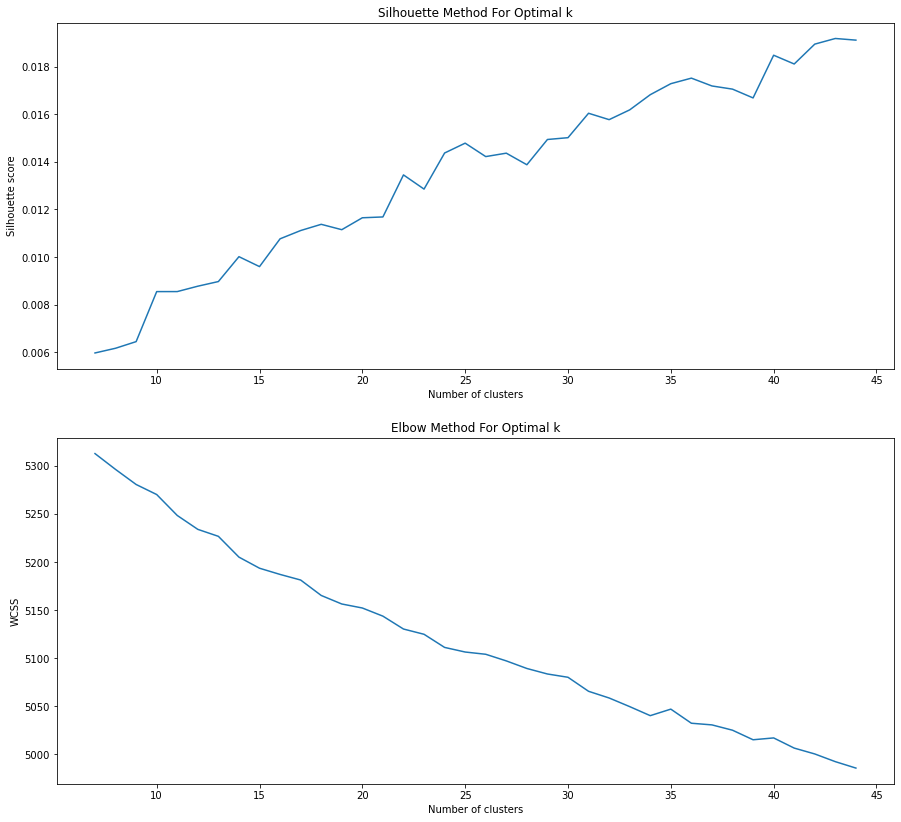

In [50]:
fig, axs = plt.subplots(nrows=2, figsize=(15,14))

ax=axs[0]
ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')

ax=axs[1]
ax.plot(K, wcss)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('WCSS')
ax.set_title('Elbow Method For Optimal k')

plt.show()

As it can be observed from the silhouette score, it appears that the most sensical number of topics is 31 (45 topics are too many and the difference in silhouette score with respect to 31 is minimal). It is worth noting that the score is quite close to 0, indicating that there are overlapping clusters. This result, however, was expected as I am not setting a limit on the number of features, making it much simpler for books to share multiple terms. Still the formation of clusters is quite interesting and it is worth studying. 

In [101]:
from sklearn.cluster import KMeans
clusters=31
model=KMeans(n_clusters=clusters, init='k-means++', max_iter=1500)
model.fit(vectors)
order_centroids=model.cluster_centers_.argsort()[:, ::-1]
cls=[]
for i in range(clusters):
    l=[]
    for j in order_centroids[i, :10]: #keeping only the first 10 words
        l.append(feature_names[j])
    print(f'Cluster {i}: {l}')
    cls.append(f'Cluster {i}')

Cluster 0: ['madame', 'de', 'monsieur', 'paris', 'mademoiselle', 'franc', 'la', 'mme', 'rue', 'france']
Cluster 1: ['officer', 'army', 'colonel', 'soldier', 'regiment', 'cavalry', 'troop', 'fort', 'gun', 'camp']
Cluster 2: ['ve', 'mrs', 'doctor', 'london', 'priest', 'john', 'captain', 'uncle', 'colour', 'england']
Cluster 3: ['mrs', 've', 'mary', 'doctor', 'aunt', 'marry', 'tea', 'dr', 'john', 'captain']
Cluster 4: ['science', 'principle', 'individual', 'social', 'moral', 'system', 'religion', 'physical', 'animal', 'philosophy']
Cluster 5: ['tom', 'sam', 'dick', 'rover', 've', 'cadet', 'roger', 'mrs', 'baxter', 'ned']
Cluster 6: ['sauce', 'butter', 'boil', 'teaspoonful', 'salt', 'pepper', 'egg', 'flour', 'pint', 'yolk']
Cluster 7: ['harry', 'jim', 've', 'mrs', 'ai', 'uncle', 'dollar', 'lad', 'colonel', 'george']
Cluster 8: ['sidenote', 'england', 'bishop', 'henry', 'oedipus', 'ship', 'government', 'footnote', 'rome', 'colony']
Cluster 9: ['illustration', 'peter', 'frederick', 'co', 'mo

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3, titles=None):
    
    fig = plt.figure(figsize=(20,20))
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    labels=np.array([f'Cluster {i}' for i in labels])
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    cm = plt.get_cmap('hsv') 
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       label=label, 
                       alpha=0.4)
        if titles.any() != None:
            books=[]
            label_seen=[]
            indexes=[]
            s=np.arange(0, len(df.label)-1)
            while len(books) != n_labels:
                a=np.random.choice(s, size=1)
                if labels[a] not in label_seen:
                    books.append(titles[a])
                    label_seen.append(labels[a])
                    indexes.append(a)
            for h in range(len(indexes)):
                ind=indexes[h][0]
                x=vectors[:, 0][ind]
                y=vectors[:, 1][ind]
                z=vectors[:, 2][ind]
                ax.scatter(x, y, z, marker='*', s=200, color='r', edgecolor='k')
                ax.text(x+0.01, y+0.01, z, books[h][0], fontsize=15)    
      
    # plot in 2 dimensions
    if dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       label=label, 
                       alpha=0.4)
        if titles.any() != None:
            books=[]
            label_seen=[]
            indexes=[]
            s=np.arange(0, len(df.label)-1)
            while len(books) != n_labels:
                a=np.random.choice(s, size=1)
                if labels[a] not in label_seen:
                    books.append(titles[a])
                    label_seen.append(labels[a])
                    indexes.append(a)
            for h in range(len(indexes)):
                ind=indexes[h][0]
                x=vectors[:, 0][ind]
                y=vectors[:, 1][ind]
                ax.scatter(x, y, marker='*', s=200, color='r', edgecolor='k')
                ax.text(x+0.01, y+0.01, books[h][0], fontsize=15)    
    else:
        raise NotImplementedError()

    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, prop={'size': 15})
    plt.show()

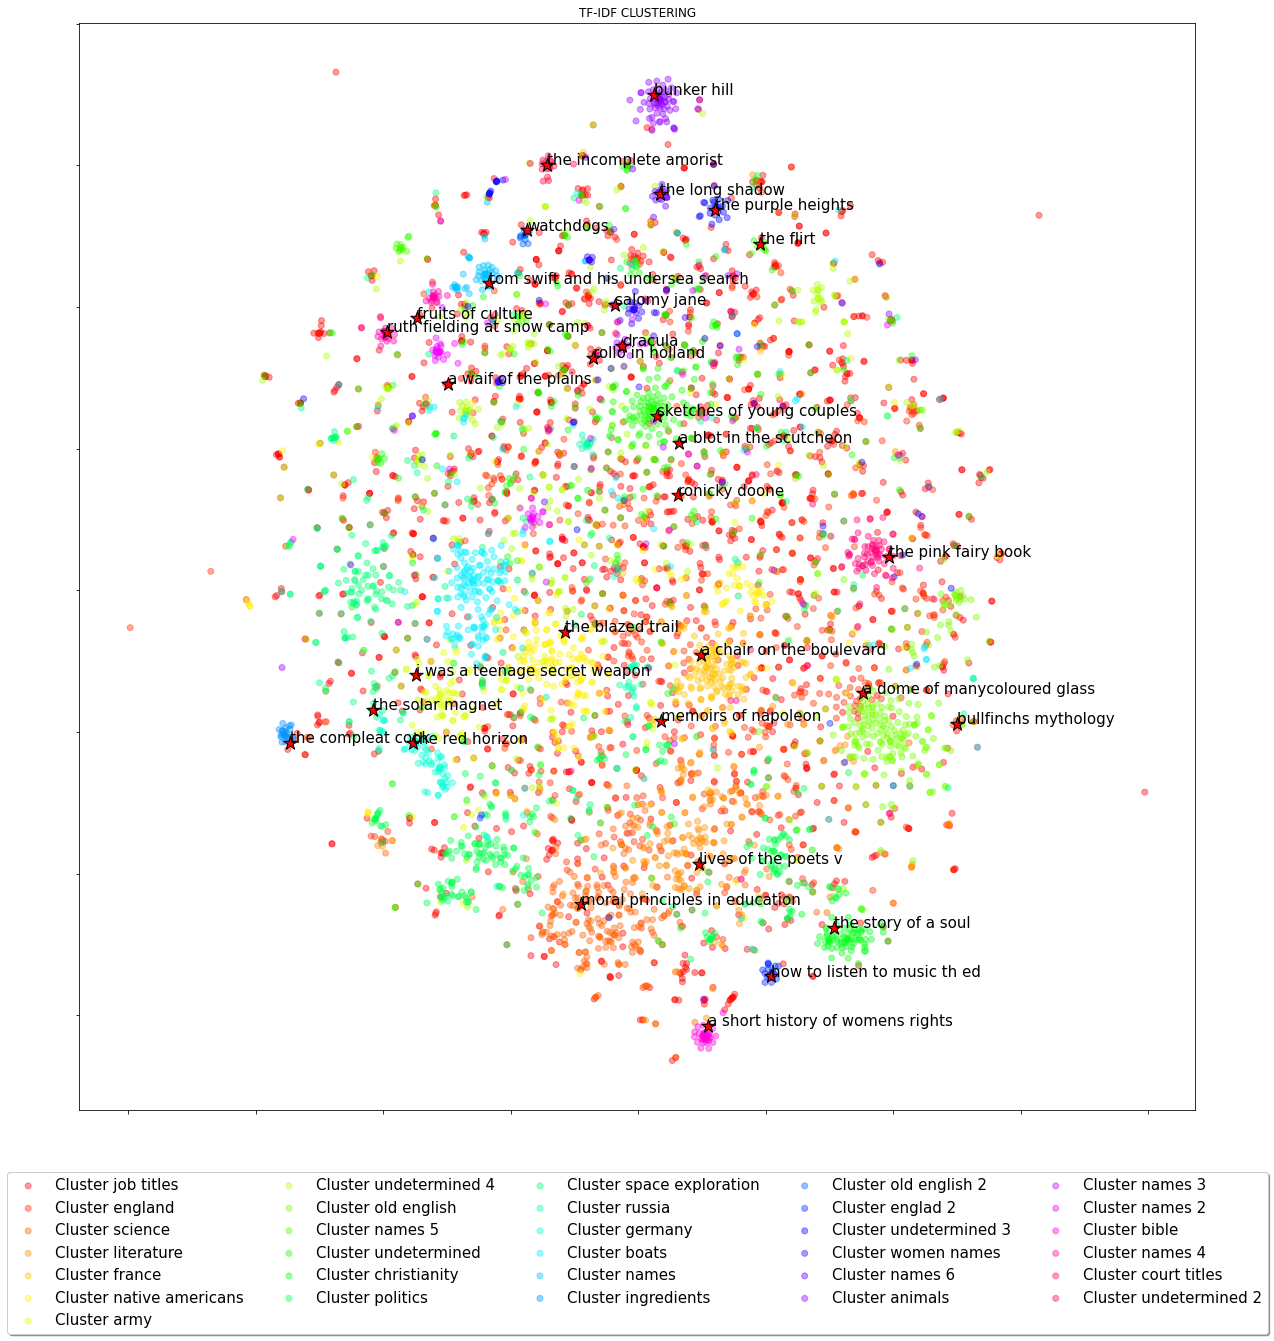

In [108]:
labels=['france', 'army', 'england', 'undetermined', 'science', 'names', 'ingredients', 'names 2', 'englad 2', 'animals', 'christianity', 'undetermined 2',
       'boats', 'old english', 'names 3', 'women names','job titles', 'undetermined 3', 'native americans', 'politics', 'russia', 'space exploration', 
        'court titles', 'germany', 'bible', 'names 4', 'old english 2', 'undetermined 4', 'names 5', 'names 6', 'literature']
#those are labels representing each cluster in 1 word.
labels_graph=[labels[i] for i in model.labels_]
t=data.Title.values
plot_vectors(tsne, 'TF-IDF CLUSTERING', labels_graph, 2, t)

From the above graphical representation, it is worth observing that books of different genres are grouped together based on the topic that they are about. As indicated from the silhouette score, there is quite some overlap between clusters, indicating that books may have features of more than 1 cluster. This of course logical as books, usually, are about multiple topics. For each cluster identified, the title of a book in it is reported.

One limitation of k-means is that it assumes that all clusters are equally sized and have the same variances. Since, from a graphical representation, this does not appear to be the case, results have to be interpreted with care. To avoid this assumption: Gaussian Mixture Modelling. Such algorithm, in fact, accounts for the possibility that each cluster can have different variance. Also, Gaussian Mixture Modelling enables to determine the probability that each point has of being part of a specific cluster. Finally, in the data it appears that there are some outliers, and, Gaussian Mixture Modelling is robust to those.

### Gaussian Mixture Modelling

In [66]:
from sklearn.mixture import GaussianMixture

In [68]:
aics = []
bics=[]
K = range(2, 40)

for c in K:
    model = GaussianMixture(c, covariance_type='diag', #to avoid a memory error, I am limiting the variance covariance matrix formed to be digaonal
                            random_state=1).fit(vectors.toarray())
    
    preds = model.fit_predict(vectors.toarray())
    #I am evaluating the model with BIC and AIC as Silhouette and WCSS did not seem to work.
    a=model.aic(vectors.toarray())
    aics.append(a)
    b=model.bic(vectors.toarray())
    bics.append(b)
    print(c, a, b)

2 -1209649893.1107078 -1209011012.8705988
3 -1222352908.908248 -1221394585.2228348
4 -1234663418.201375 -1233385651.0706577
5 -1244280134.5523443 -1242682923.976323
6 -1249053867.8617353 -1247137213.8404095
7 -1260728358.9790876 -1258492261.5124576
8 -1264176455.6759424 -1261620914.7640083
9 -1265969465.8941374 -1263094481.536899
10 -1268517884.3374848 -1265323456.5349424
11 -1270138672.953877 -1266624801.7060301
12 -1273163996.3777108 -1269330681.6845598
13 -1276389266.878438 -1272236508.7399828
14 -1278015145.2359324 -1273542943.652173
15 -1279815730.3617563 -1275024085.3326926
16 -1285679685.8115692 -1280568597.3372014
17 -1292587335.3636281 -1287156803.4439561
18 -1290638646.6017592 -1284888671.236783
19 -1292292486.0465243 -1286223067.2362437
20 -1293469179.6223216 -1287080317.366737
21 -1292279375.929776 -1285571070.228887
22 -1293202859.8321216 -1286175110.6859286
23 -1296521103.3346035 -1289173910.7431061
24 -1298362219.814248 -1290695583.7774465
25 -1299929630.7822769 -1291943

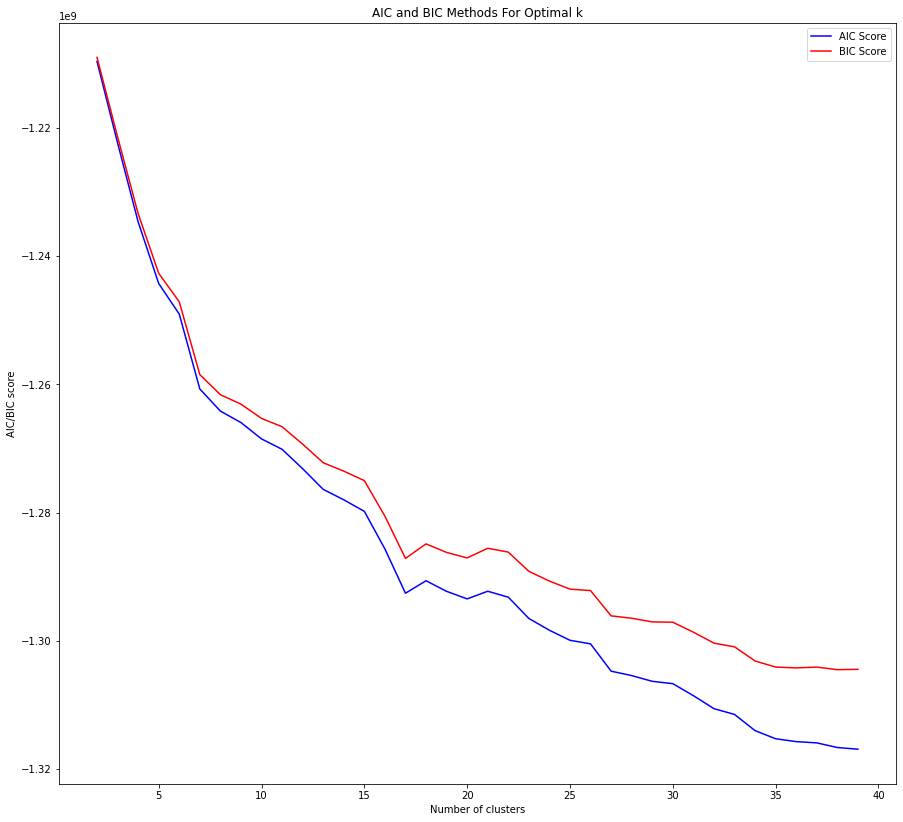

In [71]:
fig, ax = plt.subplots(figsize=(15,14))

ax.plot(K, aics, color='blue', label='AIC Score')
ax.plot(K, bics, color='red', label='BIC Score')

ax.set_xlabel('Number of clusters')
ax.set_ylabel('AIC/BIC score')
ax.set_title('AIC and BIC Methods For Optimal k')
ax.legend()

plt.show()

To identify the number of clusters, the goal is that of reducing the BIC and AIC. From the graph above, it is possible to observe that at around 35 topics, there is a stabilization of both scores, indicating that 35 topics should be used. 

In [92]:
clusters=35
model = GaussianMixture(clusters, covariance_type='diag', random_state=1)
model.fit(vectors.toarray())
order_centroids=model.means_.argsort()[:, ::-1]
cls=[]
for i in range(clusters):
    l=[]
    for j in order_centroids[i, :10]: #keeping only the first 10 words
        l.append(feature_names[j])
    print(f'Cluster {i}: {l}')
    cls.append(f'Cluster {i}')

Cluster 0: ['thou', 'er', 'hath', 'thy', 'thine', 'hast', 'ye', 'wilt', 'doth', 'thee']
Cluster 1: ['knight', 'song', 'thou', 'golden', 'sword', 'forest', 'moon', 'priest', 'ship', 'queen']
Cluster 2: ['sauce', 'boil', 'butter', 'salt', 'teaspoonful', 'pepper', 'egg', 'flour', 'pint', 'yolk']
Cluster 3: ['illustration', 'frederick', 'co', 'pussy', 'cat', 'peter', 'kitten', 'mouse', 'drawing', 'tommy']
Cluster 4: ['betty', 'polly', 'sylvia', 'paul', 'dorothy', 'patty', 'mrs', 've', 'helen', 'marian']
Cluster 5: ['ve', 'mrs', 'doctor', 'car', 'dollar', 'london', 'hat', 'george', 'uncle', 'police']
Cluster 6: ['footnote', 'ye', 'honour', 'hath', 'england', 'author', '00', 'dr', 'de', 'mrs']
Cluster 7: ['dick', 'sam', 'tom', 'rover', 've', 'baxter', 'david', 'putnam', 'dora', 'dave']
Cluster 8: ['mme', 'de', 'franc', 'paris', 'mlle', 'opera', 'la', 'madame', 'jean', 'mademoiselle']
Cluster 9: ['captain', 'jim', 've', 'ship', 'boat', 'jack', 'mrs', 'frank', 'lieutenant', 'ai']
Cluster 10: [

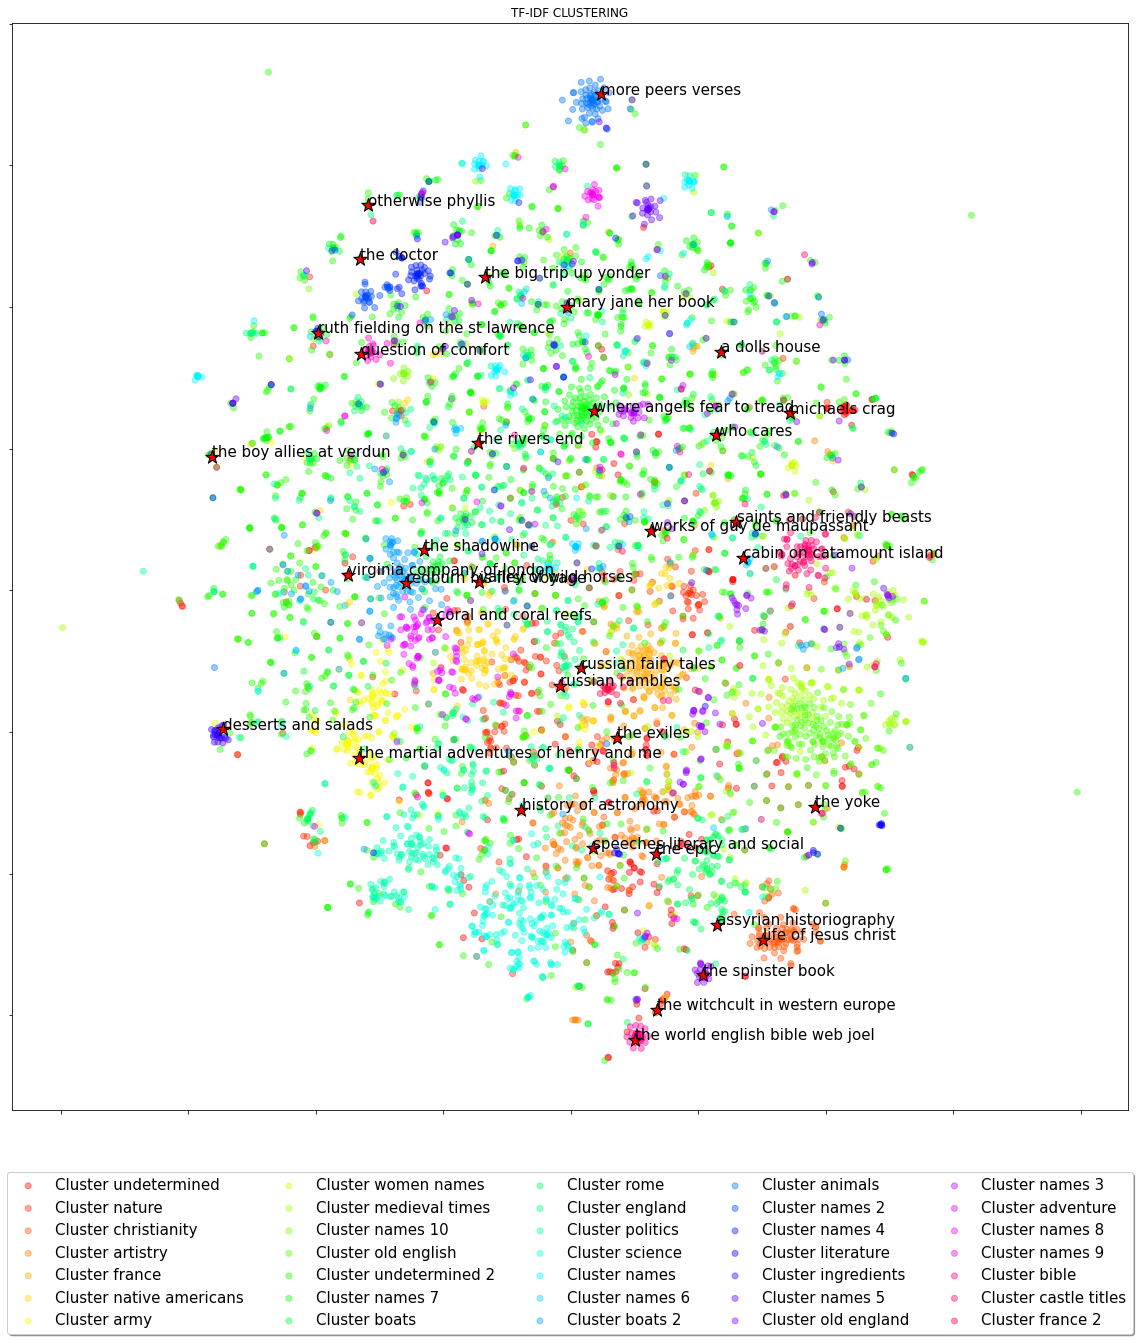

In [100]:
t=data.Title.values
labels=['old english', 'medieval times', 'ingredients', 'animals', 'names', 'england', 'undetermined','names 2','france 2' ,'boats', 'france', 'castle titles', 'rome',
       'names 3', 'undetermined 2', 'nature', 'names 4', 'names 5', 'women names', 'native americans', 'literature', 'names 6', 'names 7', 'adventure',
       'christianity', 'bible', 'boats 2', 'army', 'names 8', 'names 9', 'old england', 'science', 'names 10', 'artistry', 'politics']
#those are labels representing each cluster in 1 word. 
preds=model.predict(vectors.toarray())
labels_graph=[labels[i] for i in preds]
plot_vectors(tsne, 'TF-IDF CLUSTERING', labels_graph, 2, t)

Once again, there is quite some overlap between clusters. It is worth noting that the clusters formed through Guassian Mixture are more logical compared to those of K-means. 

The main takeaway from this clustering analysis is that the above-determined topics are not genre specific, but rather are common across books of different genres. Such finding could help users discover new books based on a topic of interest.
Recommendations, as will be shown later, can also be based on the cosine similarity between the different documents.

In [113]:
# The TF-IDF representation can be used also to compute the cosine similarity between books
similar1=similarities[0] #I am selecting the similarities of book 1
similar1=similar1[similar1<0.99] #I am excluding book 1 from the most similar
indexes=similar1.argsort()[-5:][::-1] #FInding the top 5
titles=np.array(data.Title)
print(f'Book 1 is: {titles[0]}')
print(f'The top 5 most similar books are: {titles[indexes]}')
genre=np.array(data.genres)
print(f'The genre of Book 1 is: {genre[1]}')
print(f'The genres of the top 5 most similar books are: {genre[indexes]}')
print(f'The cosine similarities are: {similar1[indexes]}')

Book 1 is: apocolocyntosis
The top 5 most similar books are: ['the last american' 'the woman who toils' 'the godidea of the ancients'
 'flying u ranch' 'm salvius otho']
The genre of Book 1 is:  classics  fantasy  20th-century  literature  fiction
The genres of the top 5 most similar books are: ['historical  non-fiction  20th-century  literature  fiction  adventure'
 'fiction' 'historical  fiction'
 ' historical-fiction  20th-century  fiction'
 'historical  non-fiction  fiction']
The cosine similarities are: [0.38208735 0.36254037 0.22413066 0.19831219 0.19454183]


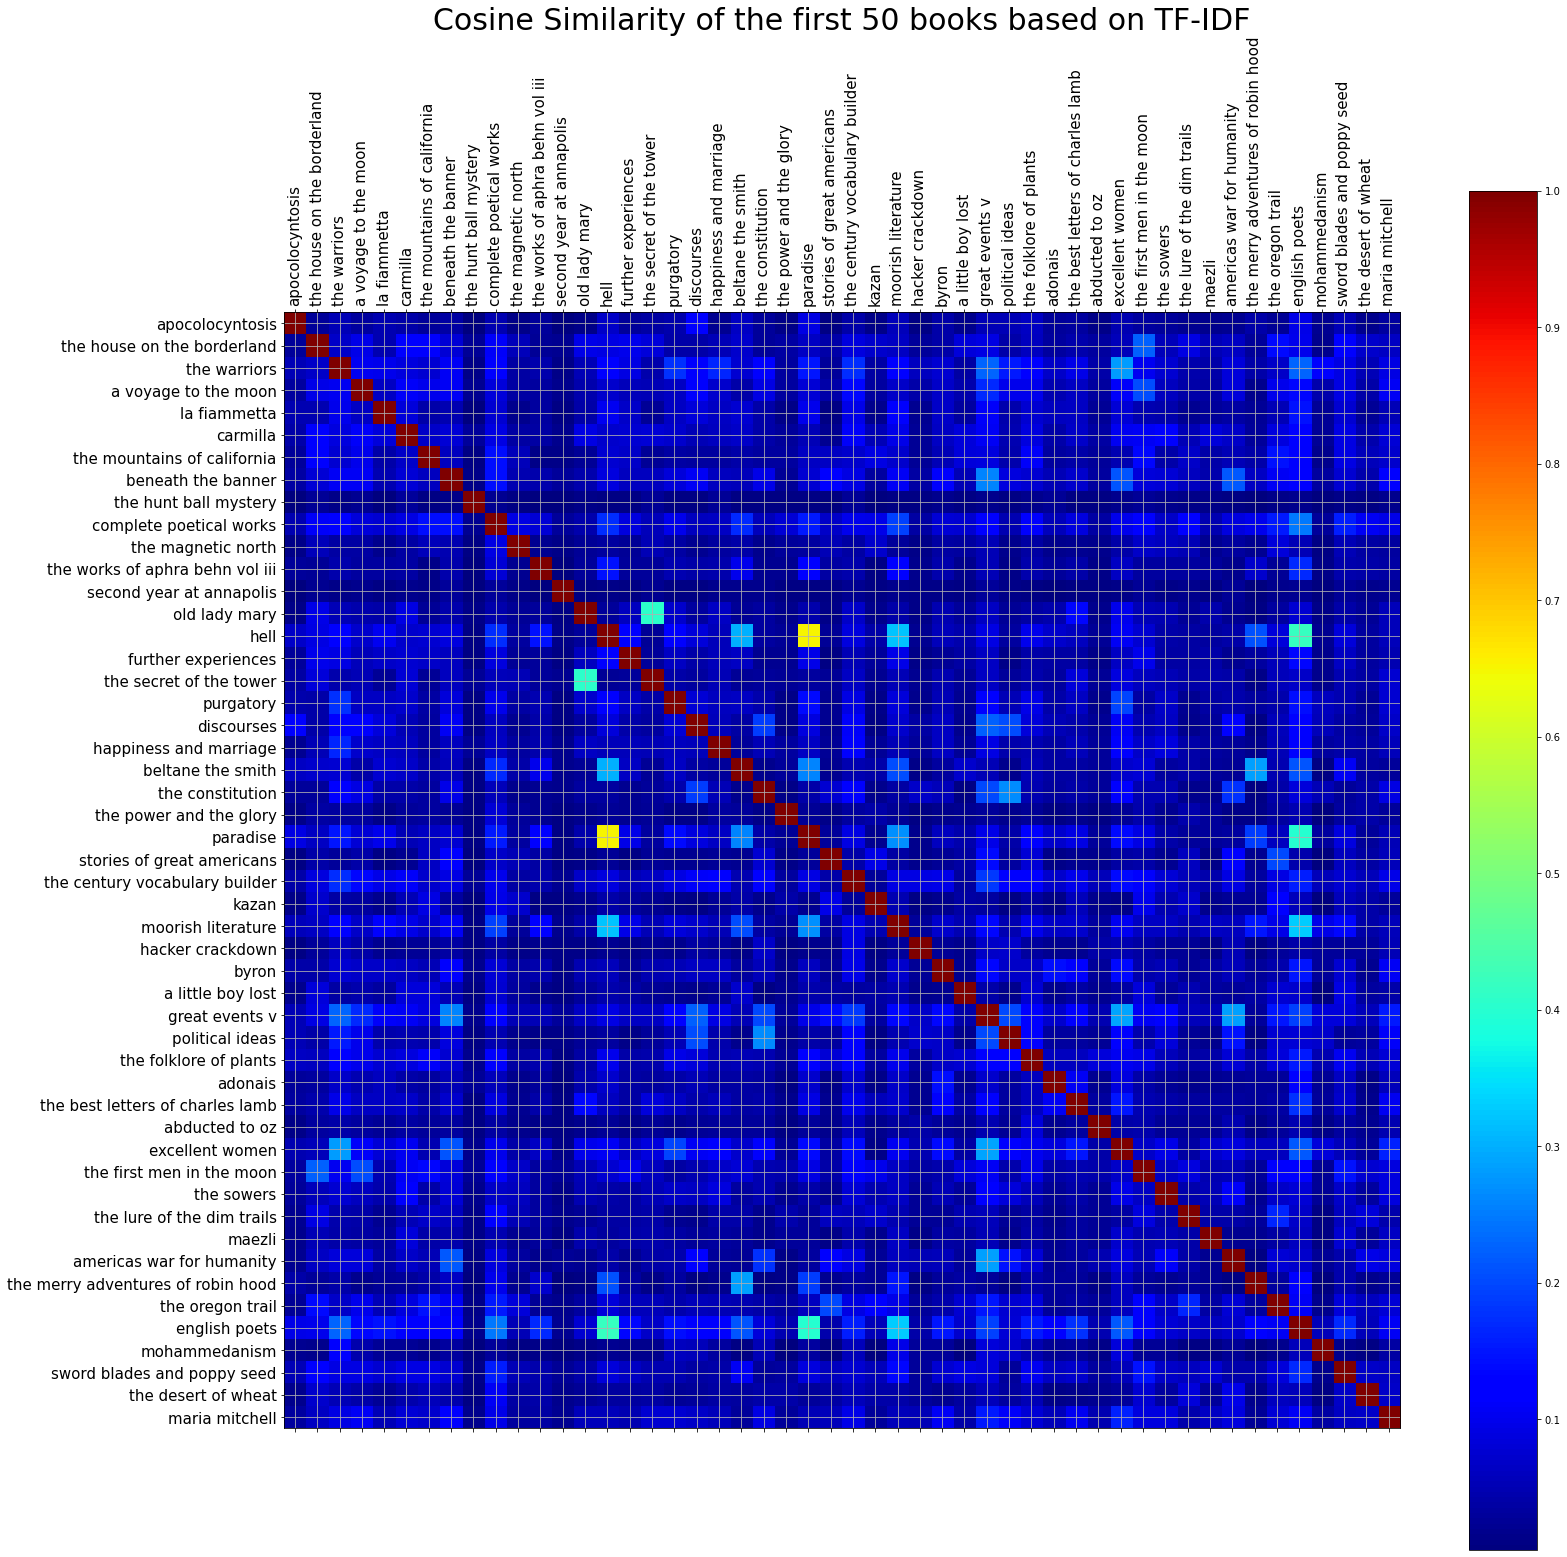

In [118]:
#Plotting the Cosine Similarity of the first 50 books based on TF-IDF
import matplotlib.pyplot as plt
from matplotlib import colors
 
labels = []
for i in range(len(data.Title)):
    labels.append(data.Title[i])

cm = plt.get_cmap('jet') 
n_labels = len(set(labels))
label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
cMap = colors.ListedColormap(label_colors)

    
start=0
end=50
fig, ax = plt.subplots(figsize=(25,25))
cax = ax.matshow(similarities[start:end, start:end], interpolation='nearest', cmap=cMap)
ax.grid(True)
plt.title('Cosine Similarity of the first 50 books based on TF-IDF', fontsize=30)
plt.xticks(range(end-start), labels[start:end], rotation=90, fontsize=15);
plt.yticks(range(end-start), labels[start:end], fontsize=15);
ticks_colors=np.arange(0, 1.05, 1/10).tolist()
fig.colorbar(cax, ticks=ticks_colors)
plt.show()
#Note that the matrix that is created is symmetric.

From this graphical representation, it is possible to observe high degrees of similarity between paradise and hell (expected as they are both by Dante Alighieri) and also between english poets and hell. Such representation provides an intuitive way to finding books that are similar to one another based on the vocabulary used. It is worth noting that meaningful representations are possible only by considering small batches of books at the time.

Given that tf-idf does not consider embeddings, Doc2Vec will be applied. This will enable to compare documents by exploiting semantic differences between them.

### Doc2Vec

In [3]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [4]:
corpus = []

for row in data.iterrows():
    label = row[1].Title #I have set the tagging to Title so that I will be able to get the representation for each book in the 
    #dataset. This will enable me to then assess the closeness of books of different genres. 
    text = row[1].text_colloc
    corpus.append(TaggedDocument(words=text.split(), 
                                 tags=[str(label)]))
    

In [5]:
d2v_model = Doc2Vec(vector_size=100, #I have noticed that changing the dimensionality to 300 yields no significant change in the results. The algorithm
                    #is much slower, so I will keep 100 dimensions
                    window=15, #I am keeping the 15 words around the word as the maximum distance
                    hs=0, #I am using negative sampling
                    sample=0.001, 
                    negative=5, #using 5 words for negative sampling
                    min_count=100, #words must appear 100 times in order to be considered
                    workers=-1, #using all cores
                    epochs=130, #number of iterations. 130 ensures that accurate results are produced
                    dm=0, #I have tried using the distributed memory architecture but the results did not change. The only thing
                    #that changed was the running time which increased
                    dbow_words=0, #Changing it between 1 and 0 yielded no results change. Also, keeping it 0 is more efficient
                    seed=1) #random seed, this will be useful to average the output across models

d2v_model.build_vocab(corpus)
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [6]:
#For the next 4 models I am keeping the parameters fixed and I am changing the random seed. This will enable me to average the results to obtain a unique 
#representation.
d2v_model1 = Doc2Vec(vector_size=100, 
                    window=15,
                    hs=0,
                    sample=0.001,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=130,
                    dm=0, 
                    dbow_words=0, 
                    seed=2)#changing the seed

d2v_model1.build_vocab(corpus)
d2v_model1.train(corpus, total_examples=d2v_model1.corpus_count, epochs=d2v_model1.epochs)

In [7]:
d2v_model2 = Doc2Vec(vector_size=100, 
                    window=15,
                    hs=0,
                    sample=0.001,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=130,
                    dm=0, 
                    dbow_words=0,
                    seed=3) #changing the seed

d2v_model2.build_vocab(corpus)
d2v_model2.train(corpus, total_examples=d2v_model2.corpus_count, epochs=d2v_model2.epochs)

In [8]:
d2v_model3 = Doc2Vec(vector_size=100, 
                    window=15,
                    hs=0,
                    sample=0.001,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=130,
                    dm=0, 
                    dbow_words=0,
                    seed=4) #changing the seed

d2v_model3.build_vocab(corpus)
d2v_model3.train(corpus, total_examples=d2v_model3.corpus_count, epochs=d2v_model3.epochs)

In [10]:
d2v_model4 = Doc2Vec(vector_size=100, 
                    window=15,
                    hs=0,
                    sample=0.001,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=130,
                    dm=0, 
                    dbow_words=0, 
                    seed=5) #changing the seed

d2v_model4.build_vocab(corpus)
d2v_model4.train(corpus, total_examples=d2v_model4.corpus_count, epochs=d2v_model4.epochs)

In [11]:
document_embeddings=np.zeros((data.shape[0],100)) #creating a 5713 X 100 dimensional array to store the resulting vectors of doc2vec

#averaging the vector representation of each book 
for i in range(len(document_embeddings)):
    document_embeddings[i]=(d2v_model1.dv[i]+ d2v_model.dv[i]+ d2v_model2.dv[i]+ d2v_model3.dv[i]+ d2v_model4.dv[i])/5
    
from sklearn.metrics.pairwise import cosine_similarity
pairwise_similarities=cosine_similarity(document_embeddings) #Matrix that contains the parwise similarities across books

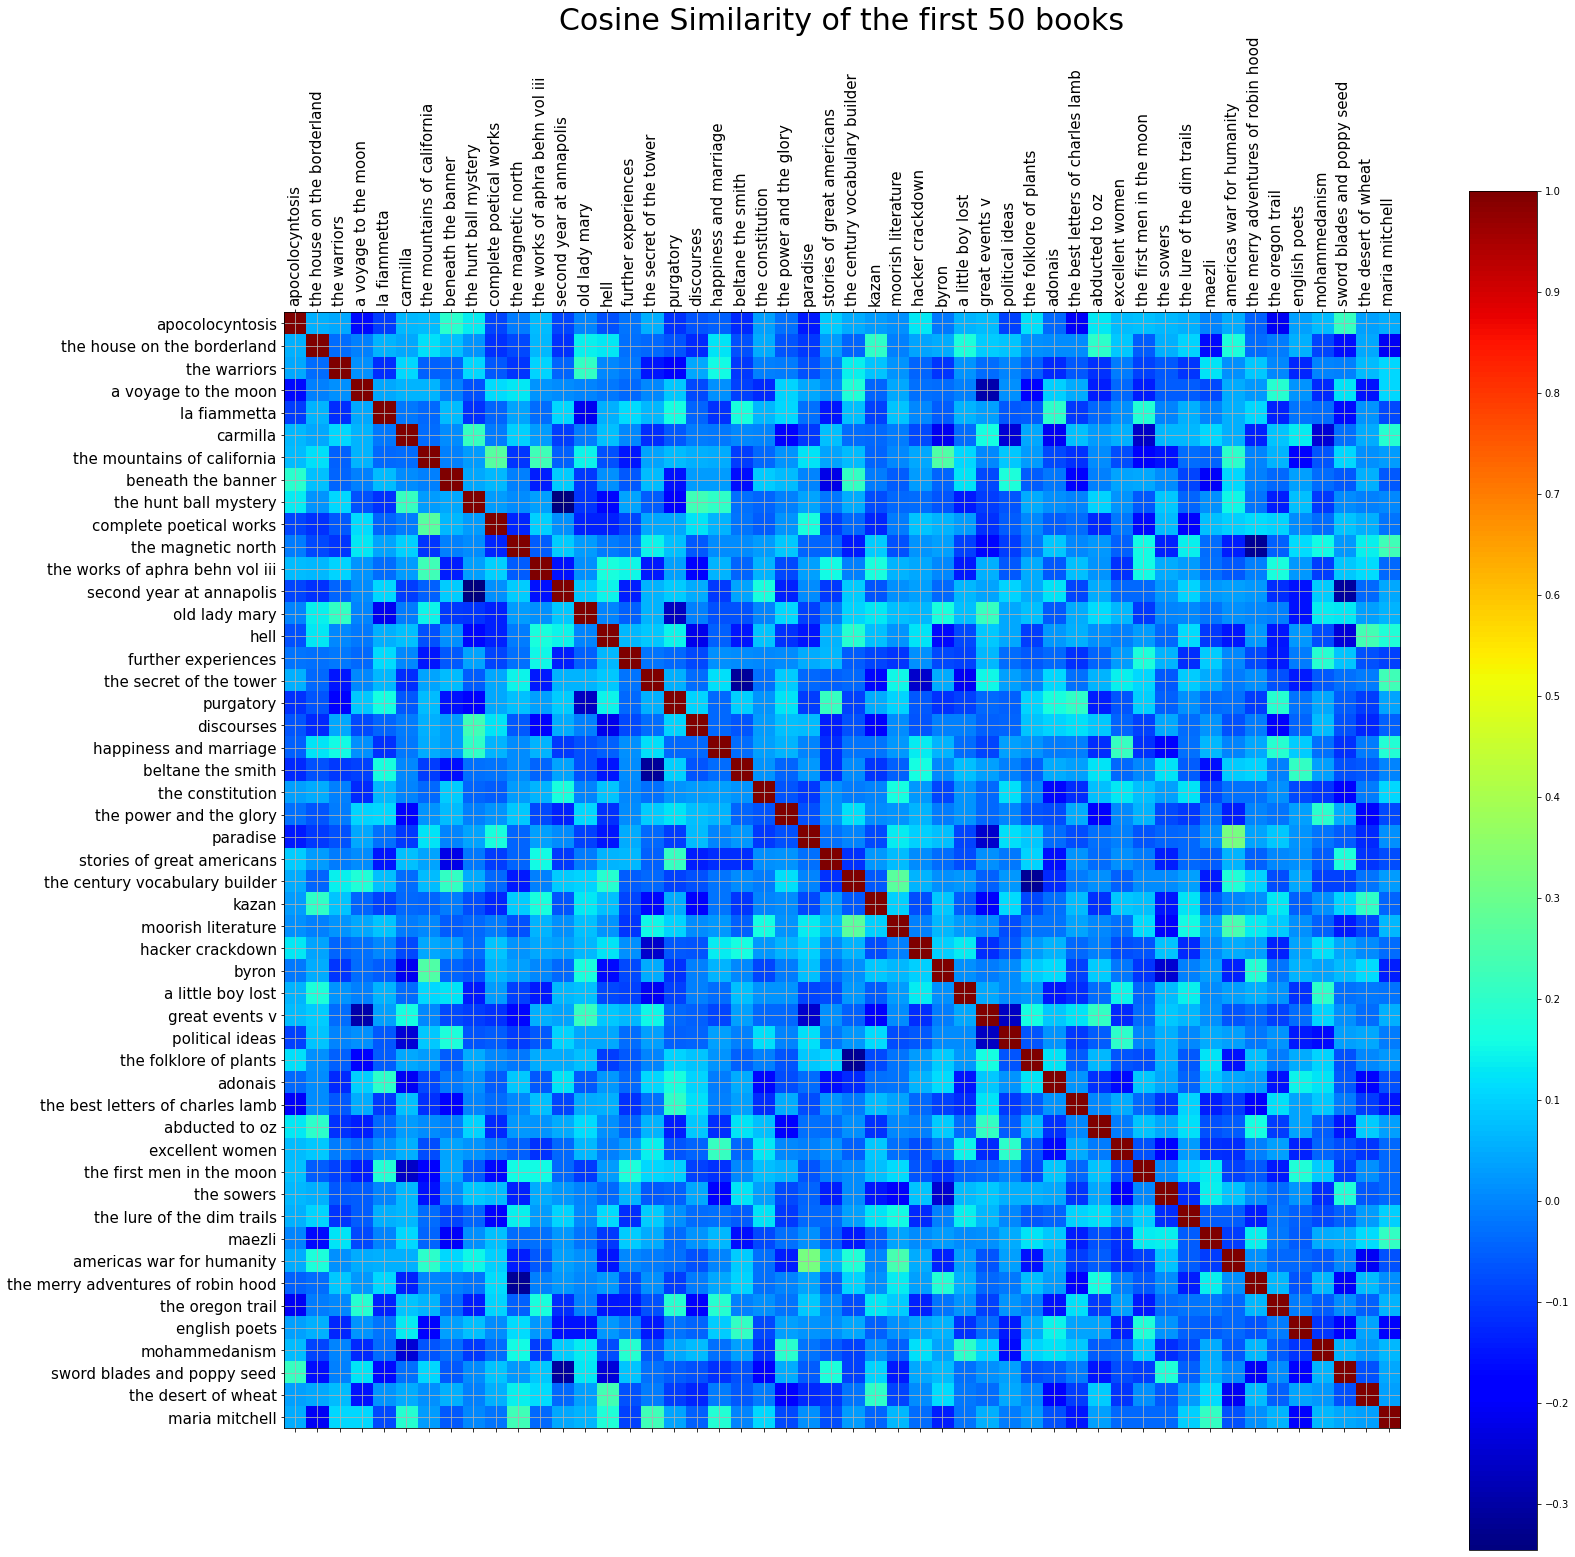

In [12]:
#Plotting the Cosine Similarity of the first 50 books
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
 
labels = []
for i in range(len(data.Title)):
    labels.append(data.Title[i])

cm = plt.get_cmap('jet') 
n_labels = len(set(labels))
label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
cMap = colors.ListedColormap(label_colors)

    
start=0
end=50
fig, ax = plt.subplots(figsize=(25,25))
cax = ax.matshow(pairwise_similarities[start:end, start:end], interpolation='nearest', cmap=cMap)
ax.grid(True)
plt.title('Cosine Similarity of the first 50 books', fontsize=30)
plt.xticks(range(end-start), labels[start:end], rotation=90, fontsize=15);
plt.yticks(range(end-start), labels[start:end], fontsize=15);
ticks_colors=np.arange(-0.3, 1.05, 1/10).tolist()
fig.colorbar(cax, ticks=ticks_colors)
plt.show()

From the graph it is possible to notice that there are interesting cosine similarities between the first 50 books. In fact, it is possible to note that for many books the cosine similarities are around 0.2, 0.3 which is quite high considering the size of each document. 

In [13]:
a=pairwise_similarities
a=a[a<0.99] # I am setting 0.99 as there are some cosine similarities of 0.999999999 which are between the book and itself
ind=np.argsort(a)[::-1]
print(f'Top 5 Cosine similarities in the entire dataset: {a[ind[:5]]}')
#As it can be seen, the 5 highest cosine similarities found are quite small

a=pairwise_similarities[start:end, start:end]
a=a[a<0.99] # I am setting 0.99 as there are some cosine similarities of 0.999999999 which are between the book and itself
ind=np.argsort(a)[::-1]
print(f'Top 5 Cosine similarities in the graph above: {a[ind[:5]]}')

Top 5 Cosine similarities in the entire dataset: [0.51072723 0.51072723 0.49882573 0.49882573 0.48703412]
Top 5 Cosine similarities in the graph above: [0.32003547 0.32003547 0.27190095 0.27190095 0.26488727]


In [15]:
from sklearn.manifold import TSNE
tsne=TSNE(2, metric = 'cosine', random_state=2).fit_transform(document_embeddings) #I am using as a metric the cosine similarity
tsne.shape
#Right now, I have compressed the 100 dimensions that each document has into 2. Through this dimensionality reduction technique
#it is then possible to represent each document as a point in a 2-dimensional space

C:\Users\fabio\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


(5713, 2)

In [25]:
#Coloring. I am assigning colos to books that are part only of one specific genre. The rationale is that those books should be the ones that are more far 
#apart from one another compared to books that are part of multiple genres.
data['color']='gray' #assigning color gray to all books
d={'fiction':'red', 'non_fiction': 'aqua', 'classics': 'orange', 'historical':'yellow', '20th-century':'darkolivegreen',
                  'historical-fiction':'lime', 'literature':'dodgerblue', 'romance':'navy', 
                  'fantasy':'magenta', 'adventure':'brown', 'more than 1 genre':'gray'} #dictionary of colors for the individual genres
for i in range(len(data.genres)):
    if sum((data['fiction'][i], data['non-fiction'][i], data['classics'][i], data['historical'][i], data['20th-century'][i],
           data['historical-fiction'][i], data['literature'][i], data['romance'][i], data['fantasy'][i], data['adventure'][i]))==1:
        data.loc[i, 'color']=d[data.genres[i].strip()] 
colors_l=data.color.tolist()

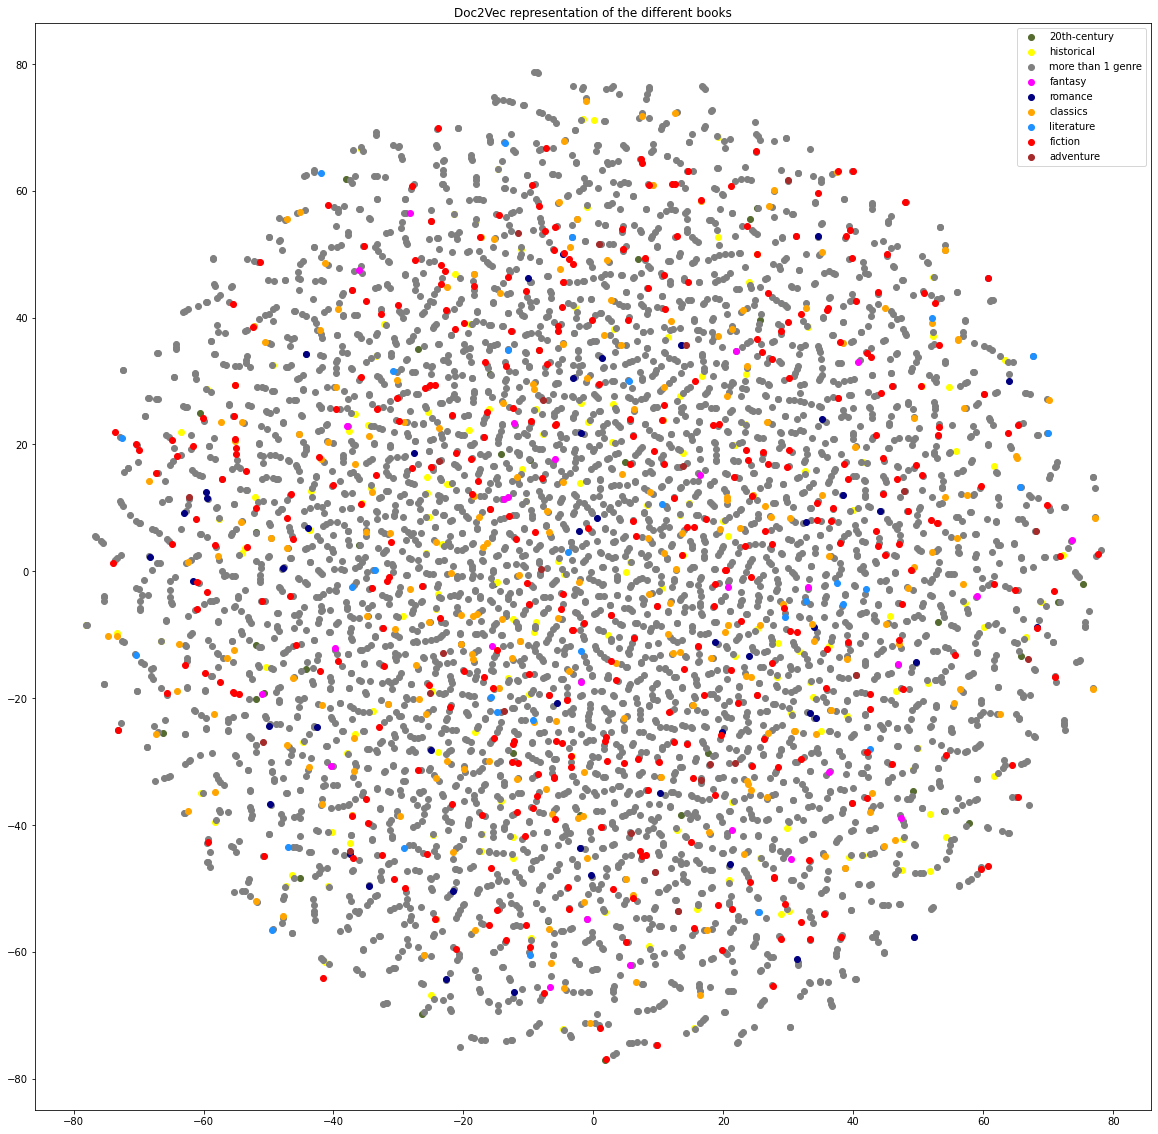

In [28]:
df = pd.DataFrame(data={'x':tsne[:,0], 'y': tsne[:,1]})
df['colors']=colors_l
fig, ax = plt.subplots(figsize=(20,20))
for i in set(colors_l):
    a=df[df['colors']==i]
    for k, v in d.items():
        if v == i:
            b=k
            ax.scatter(a['x'], a['y'], color=i, label=b)
            break
ax.set_title('Doc2Vec representation of the different books')
ax.legend()
plt.show()

Such representation shows that there are no clear clusters formed when representing the document embeddings of the different books. This result was obtained even after tuning the different parameters of Doc2Vec and of T-SNE. I will now try using SVD
to check whether I can obtain more meaningful representations.

### SVD

In [29]:
from sklearn.decomposition import TruncatedSVD 
svd = TruncatedSVD(n_components=2)
U = svd.fit_transform(document_embeddings)
S = svd.singular_values_
V = svd.components_
U.shape

(5713, 2)

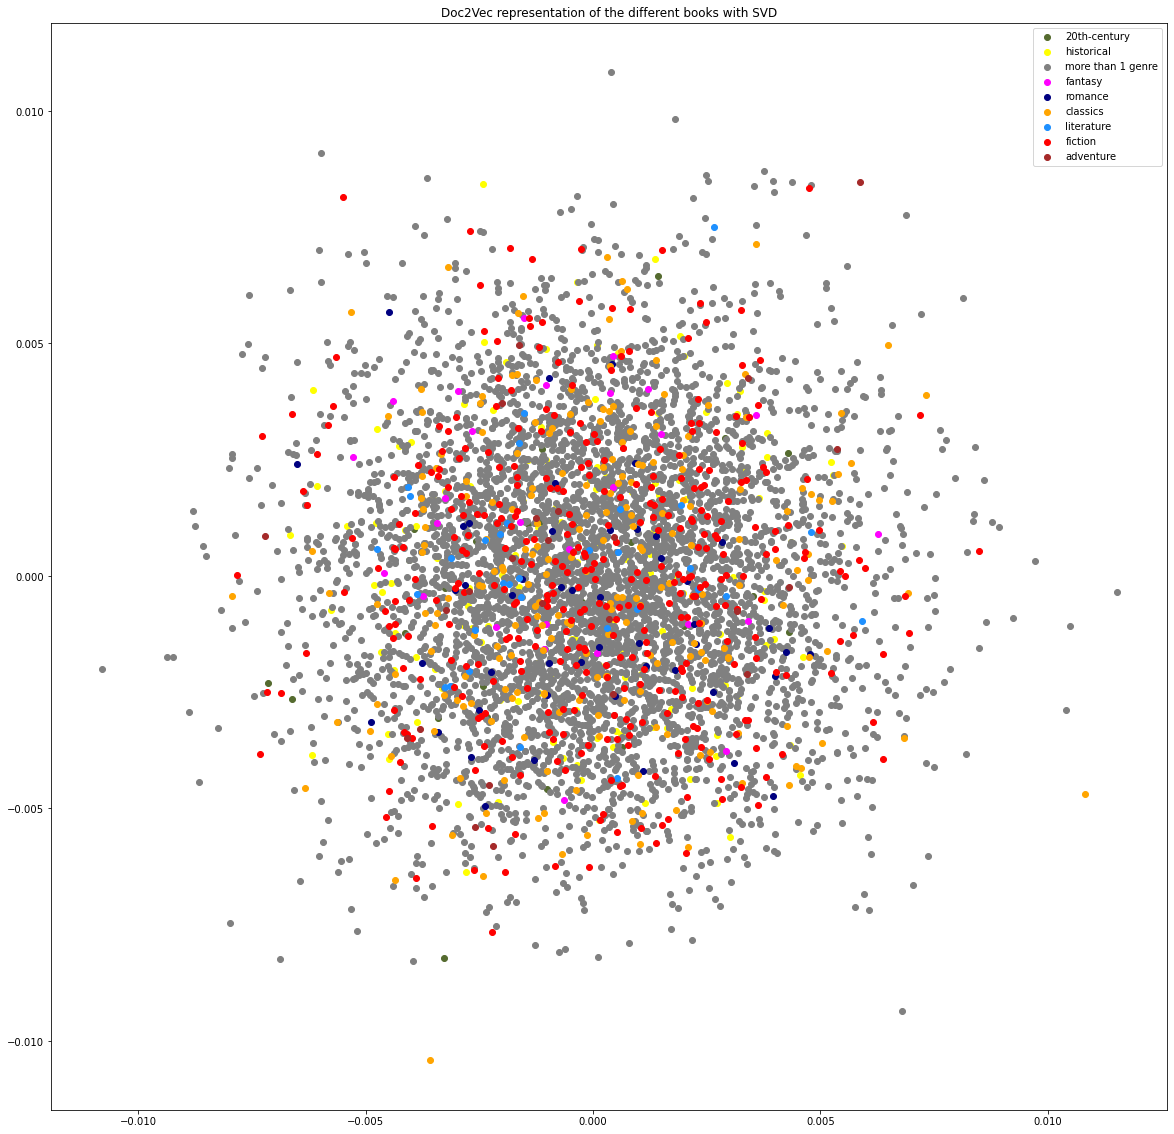

In [31]:
df = pd.DataFrame(data={'x':U[:,0], 'y': U[:,1]})
df['colors']=colors_l
fig, ax = plt.subplots(figsize=(20,20))
for i in set(colors_l):
    a=df[df['colors']==i]
    for k, v in d.items():
        if v == i:
            b=k
            ax.scatter(a['x'], a['y'], color=i, label=b)
            break
ax.set_title('Doc2Vec representation of the different books with SVD')
ax.legend()
plt.show()

Once again, it is not possible to discern similarities between books of the same genre. The data, once again, does not seem to form any cluster. 

After having seen the absence of clusters, I will try to use a different way to represent document embeddings via Bert.

In [33]:
#pip install sentence-transformers
from sentence_transformers import SentenceTransformer
model_bert = SentenceTransformer('bert-base-nli-max-tokens')
embedding_bert = np.array(model_bert.encode(corpus, show_progress_bar=True))

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/397 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/179 [00:00<?, ?it/s]

In [34]:
embedding_bert.shape #each document now has 768 dimensions

(5713, 768)

In [39]:
data['color']='gray' #assigning color gray to all books
d={'fiction':'red', 'non_fiction': 'aqua', 'classics': 'orange', 'historical':'yellow', '20th-century':'darkolivegreen',
                  'historical-fiction':'lime', 'literature':'dodgerblue', 'romance':'navy', 
                  'fantasy':'magenta', 'adventure':'brown', 'more than 1 genre':'gray'} #dictionary of colors for the individual genres
for i in range(len(data.genres)):
    if sum((data['fiction'][i], data['non-fiction'][i], data['classics'][i], data['historical'][i], data['20th-century'][i],
           data['historical-fiction'][i], data['literature'][i], data['romance'][i], data['fantasy'][i], data['adventure'][i]))==1:
        data.loc[i, 'color']=d[data.genres[i].strip()] 
colors_l=data.color.tolist()

In [36]:
from sklearn.manifold import TSNE
tsne=TSNE(2, metric = 'cosine', random_state=2).fit_transform(embedding_bert)

C:\Users\fabio\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


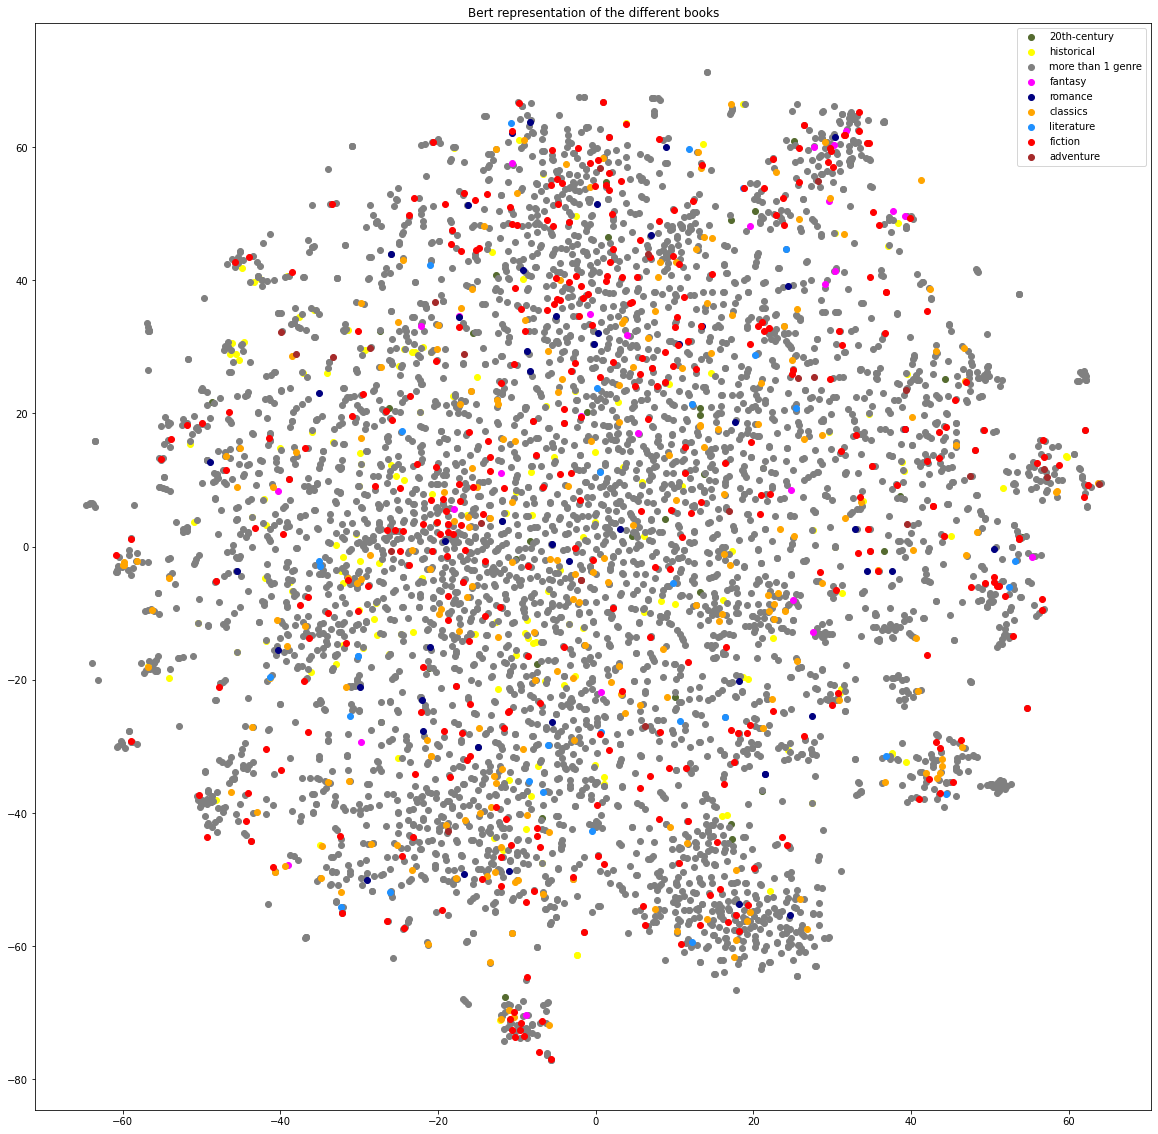

In [42]:
df = pd.DataFrame(data={'x':tsne[:,0], 'y': tsne[:,1]})
df['colors']=colors_l
fig, ax = plt.subplots(figsize=(20,20))
for i in set(colors_l):
    a=df[df['colors']==i]
    for k, v in d.items():
        if v == i:
            b=k
            ax.scatter(a['x'], a['y'], color=i, label=b)
            break
ax.set_title('Bert representation of the different books')
ax.legend()
plt.show()

Interestingly, following the Bert representation it is possible to observe the formation of clusters. Once again, those clusters are not genre specific. I will now try to determine how many clusters are formed. 

In [45]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouettes = []
wcss=[]
K = range(2, 35)

for c in K:
    kmeans_clustering = KMeans(n_clusters=c, init='k-means++', max_iter=500)
    kmeans_ids = kmeans_clustering.fit_predict(embedding_bert)
    score = silhouette_score(embedding_bert, kmeans_clustering.labels_)
    silhouettes.append(score)
    wcss.append(kmeans_clustering.inertia_)
    print(c, score, kmeans_clustering.inertia_)

2 0.046885915 355244.75
3 0.047106475 344146.625
4 0.03986081 336452.4375
5 0.040897995 330838.96875
6 0.032072976 325808.15625
7 0.033366263 321226.71875
8 0.03648514 317418.625
9 0.03242597 314270.6875
10 0.03264819 311278.25
11 0.030719562 308459.28125
12 0.03058022 306474.59375
13 0.030868528 304308.875
14 0.028891856 302561.8125
15 0.026955713 300953.09375
16 0.029982086 299091.59375
17 0.031219589 297414.59375
18 0.033143457 295608.46875
19 0.029113136 294590.15625
20 0.0238906 293477.8125
21 0.026707148 292156.9375
22 0.02450967 290683.875
23 0.02783937 289014.53125
24 0.029332303 288225.40625
25 0.023626016 286962.21875
26 0.028216388 286124.3125
27 0.02635141 284810.21875
28 0.023397762 284435.0
29 0.025766272 283146.78125
30 0.025972778 282165.75
31 0.021451863 281644.96875
32 0.02398782 280636.78125
33 0.0225754 280102.0625
34 0.025318418 279339.84375


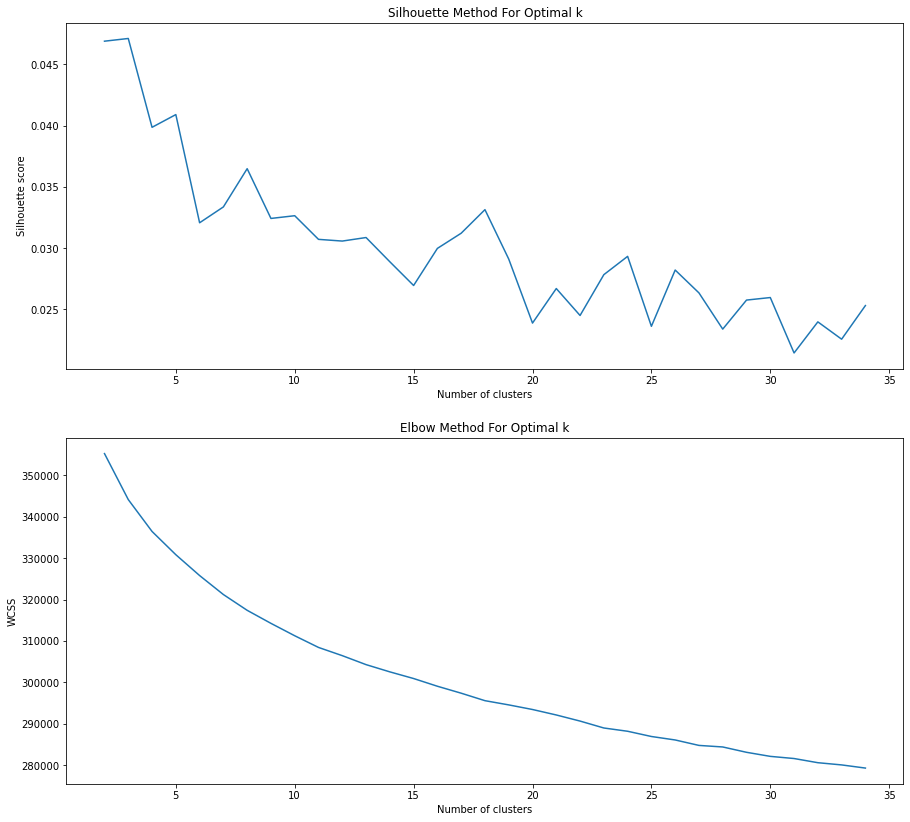

In [46]:
fig, axs = plt.subplots(nrows=2, figsize=(15,14))

ax=axs[0]
ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')

ax=axs[1]
ax.plot(K, wcss)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('WCSS')
ax.set_title('Elbow Method For Optimal k')

plt.show()

Although the silhouette score is still low, suggesting that clusters have some overlap, the final score is higher than that observed in tf-idf analysis. This indicates that the clusters formed with Bert are more separated from one another.

In [48]:
from sklearn.cluster import KMeans
clusters=3
model=KMeans(n_clusters=clusters, init='k-means++', max_iter=1500)
model.fit(embedding_bert)

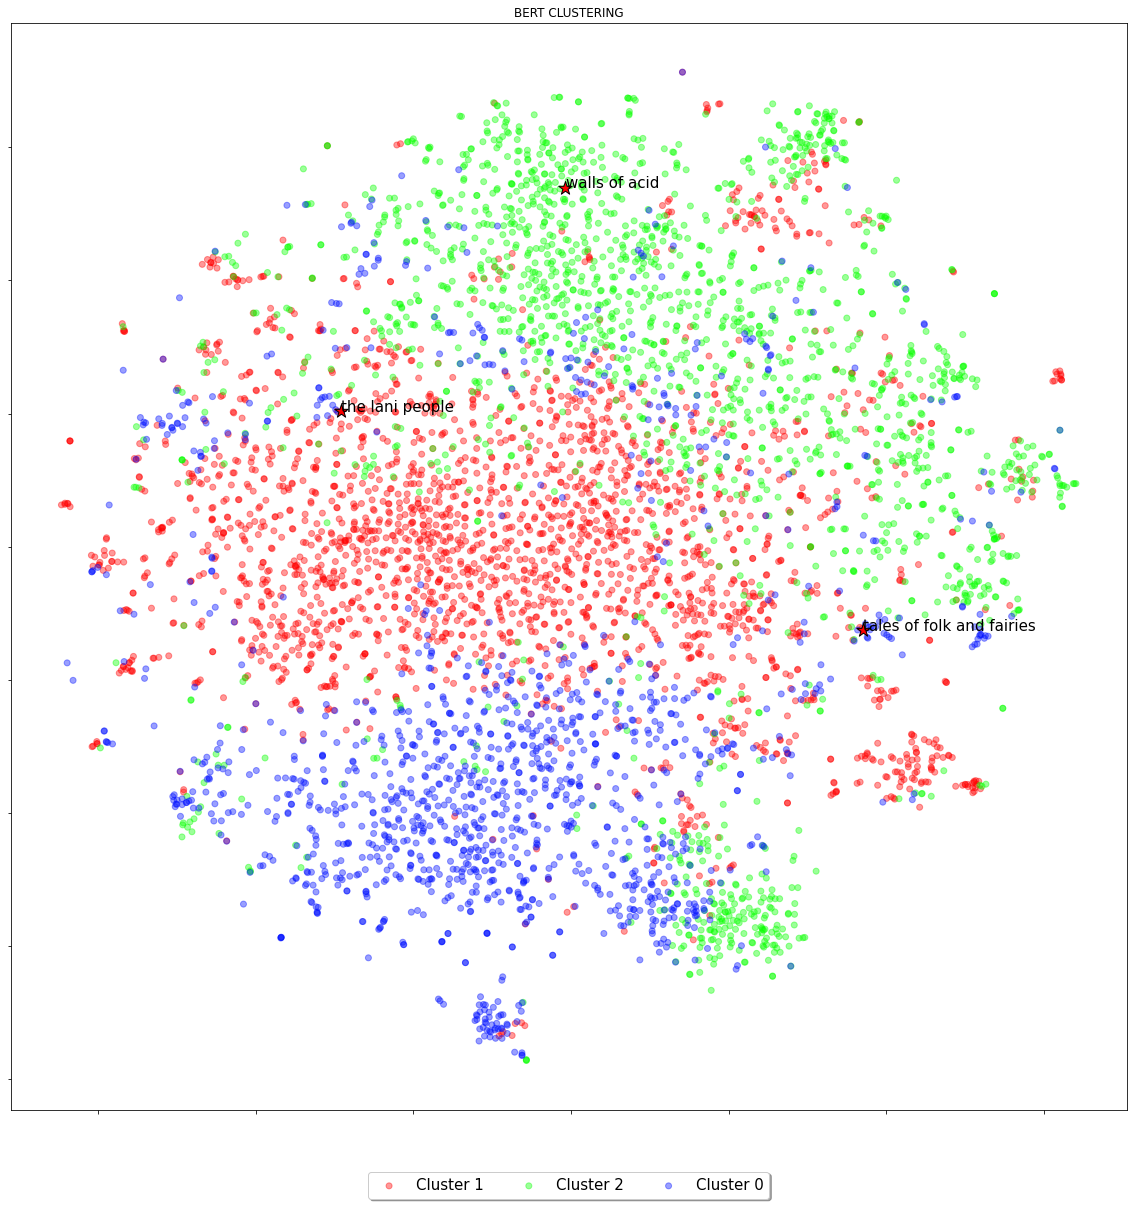

In [52]:
t=data.Title.values
plot_vectors(tsne, 'BERT CLUSTERING', model.labels_, 2, t)

From this graphical representation it is possible to observe the presence of overlap between clusters. One limitation of using document embeddings is that it is not possible to determine commonalities between books in the same cluster. This result is still useful as books could be recommended to users based on whether they are part of the same cluster.

In [87]:
from sklearn.mixture import GaussianMixture
aics = []
bics=[]
K = range(2, 30)

for c in K:
    model = GaussianMixture(c, covariance_type='diag', #to avoid a memory error, I am limiting the variance covariance matrix formed to be digaonal
                            random_state=1).fit(embedding_bert)
    
    preds = model.fit_predict(embedding_bert)
    #I am evaluating the model with BIC and AIC as Silhouette and WCSS did not seem to work.
    a=model.aic(embedding_bert)
    aics.append(a)
    b=model.bic(embedding_bert)
    bics.append(b)
    print(c, a, b)

2 677947.2354627755 698384.2206067357
3 537490.596100637 568149.3990663567
4 440615.59745355323 481496.2182410325
5 363173.7665990124 414276.2052082512
6 321017.90126869717 382342.15769969544
7 255202.6641716063 326748.73842436407
8 183024.35867747184 264792.2507519891
9 140264.36205553426 232254.07195181103
10 107216.4480281153 209427.97574615155
11 83004.24014666276 195437.5856864585
12 55481.320503250696 178136.48386480595
13 28813.96089939492 161690.94208270966
14 8406.697000524 151505.49600559825
15 -9121.320017812875 144199.29680902086
16 -32891.976350218305 130650.45829837494
17 -55433.92259701596 118330.32987333678
18 -78190.45384358458 105795.61644852767
19 -92865.34108087237 101342.54703299937
20 -110819.93154185178 93609.77439377946
21 -147741.7947446539 66909.72901273685
22 -161874.8693331151 62998.47224603515
23 -179107.84418696875 55987.31521394098
24 -193100.3474232735 52216.62979939574
25 -204005.5317814452 51533.26326298353
26 -208959.91823901644 56800.69462717179
27 -

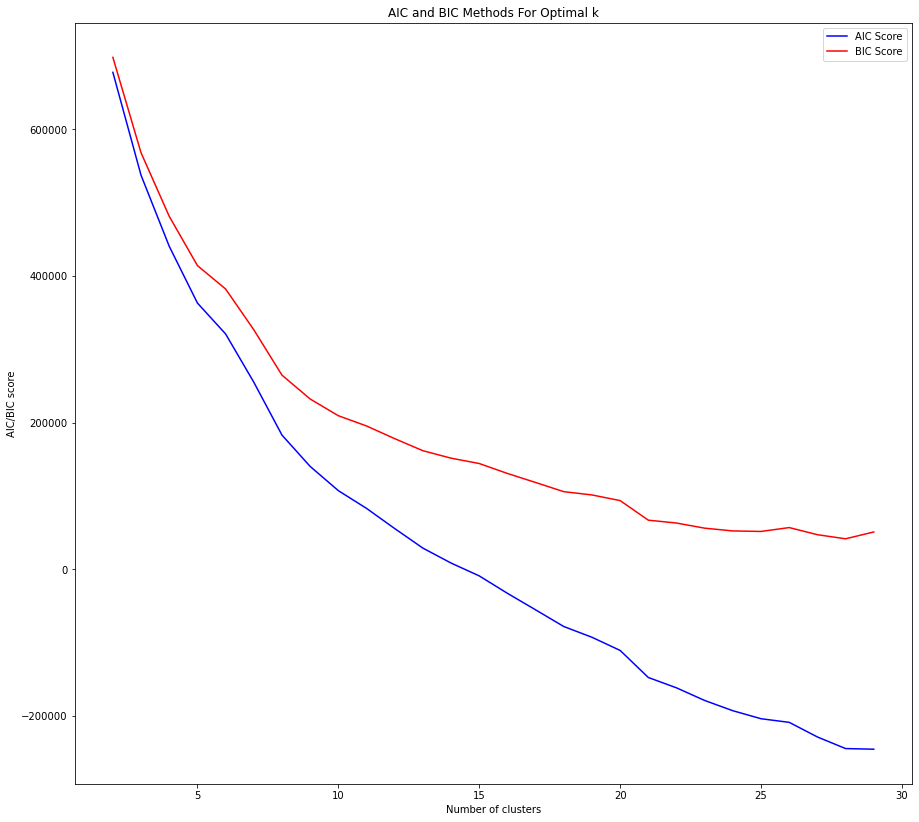

In [88]:
fig, ax = plt.subplots(figsize=(15,14))

ax.plot(K, aics, color='blue', label='AIC Score')
ax.plot(K, bics, color='red', label='BIC Score')

ax.set_xlabel('Number of clusters')
ax.set_ylabel('AIC/BIC score')
ax.set_title('AIC and BIC Methods For Optimal k')
ax.legend()

plt.show()

By looking at the graph, it is possible to observe that BIC stabilizes at 20 topics and also a trend towards stabilization appears in AIC. I will thus use 20 topics and evaluate the clusters formed.

In [89]:
clusters=20
model = GaussianMixture(clusters, covariance_type='diag', random_state=1)
model.fit(embedding_bert)

GaussianMixture(covariance_type='diag', n_components=20, random_state=1)

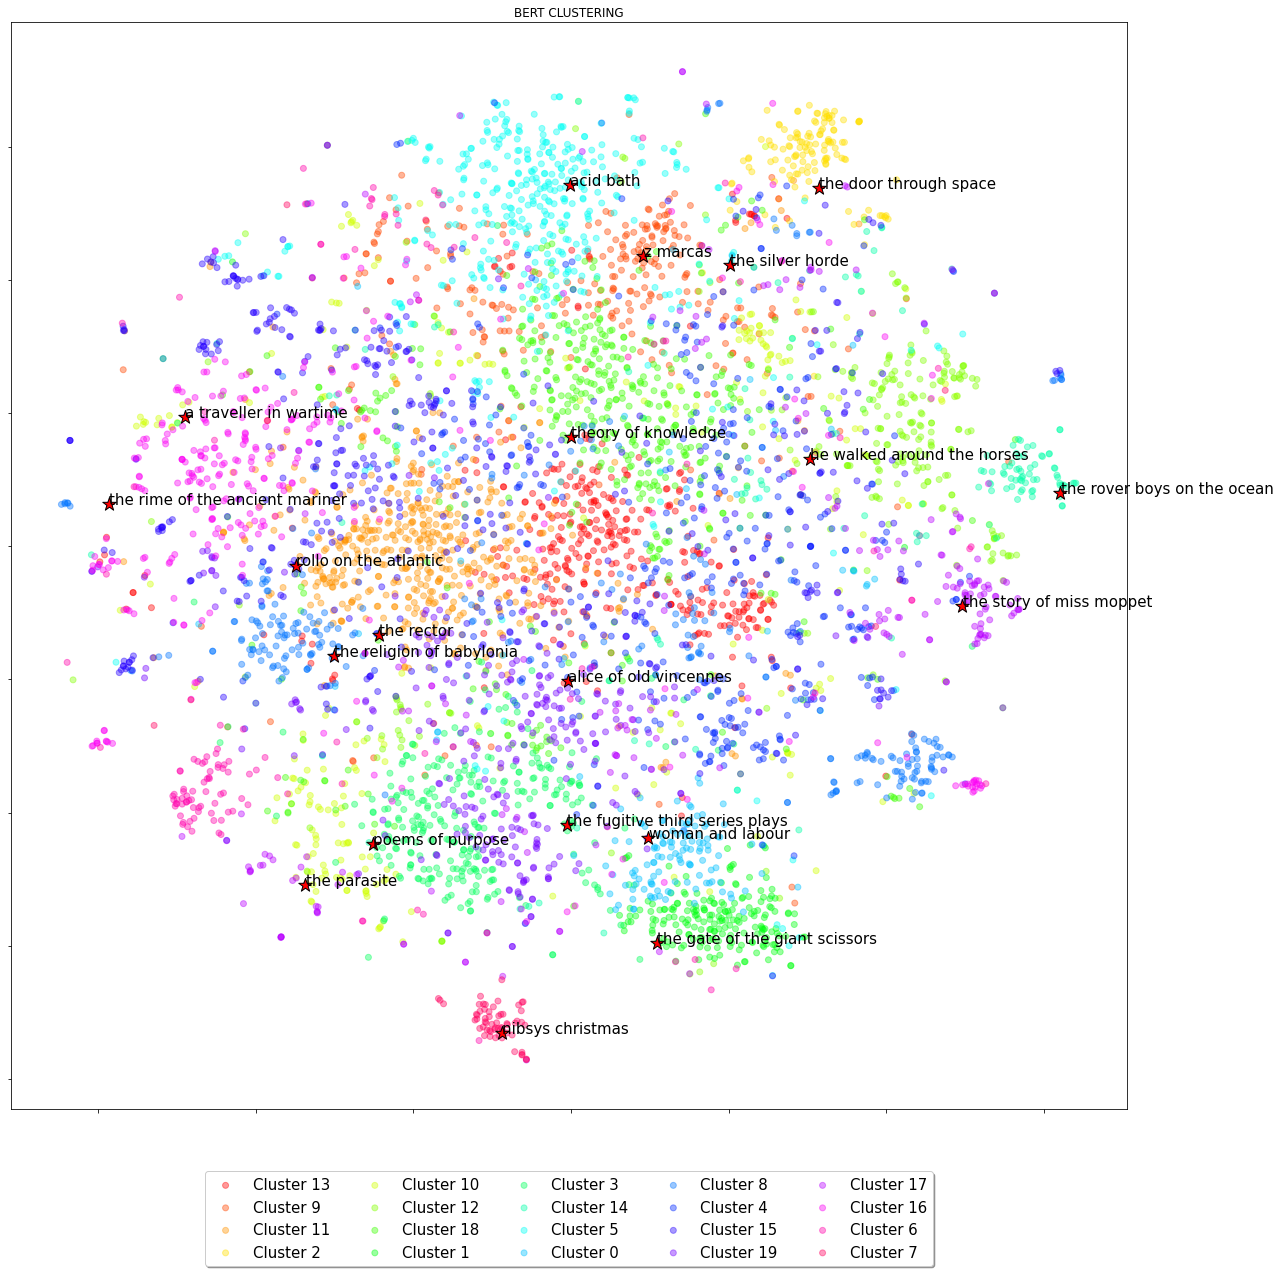

In [91]:
preds=model.predict(embedding_bert)
plot_vectors(tsne, 'BERT CLUSTERING', preds, 2, t)

From this representation, it is possible to distinguish 20 clear clusters in the data. However, given that the points arise from a document embedding representation, it is impossible to characterize those clusters based on their content. This observation, motivates the investigation of the similarities of books by comparing their content through topic models.

### LDA

In [3]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
import multiprocessing
from gensim.corpora import Dictionary
import sys 
output_stream = sys.stdout

In [4]:
words_perbook = data['text_colloc'].apply(str.split).tolist()

In [5]:
dictionary = Dictionary(words_perbook)
dictionary.filter_extremes(no_below=50, no_above=0.3) 
print(f'Dictionary Created')
ldacorpus=[]
for j in range(len(words_perbook)):
    ldacorpus.append(dictionary.doc2bow(words_perbook[j]))
    output_stream.write('Books seen %s\r' % j)
    output_stream.flush()
tfidf = TfidfModel(ldacorpus)
model_corpus = tfidf[ldacorpus]

Dictionary Created


In [225]:
numtop=[]
coherence_umass = []
coherence_cv=[]

for num_topics in range(2, 33): #given that multiple clusters were formed through the TF-IDF and the Bert representation, 
                                #I will consider multiple topics also here
    model = LdaMulticore(corpus=model_corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42,
                         passes=1) #limiting the number of passes to limit the running time
                         
    

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=words_perbook, 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=words_perbook, 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    numtop.append(num_topics)
    coherence_umass.append(umass_score)
    coherence_cv.append(cv_score)

2 -1.410574049149187 0.18371917343411082
3 -1.4748600447979883 0.19912315666263417
4 -1.6093197014611444 0.21331504559772918
5 -1.4928354587496806 0.20555052181620354
6 -1.5252174548780328 0.2130493948141734
7 -1.5490091211286017 0.2359285362634537
8 -1.5937606906484716 0.21307675885198246
9 -1.5574048087953338 0.20177451696029672
10 -1.6106861298396407 0.20247112129257722
11 -1.7536342038147956 0.2114663847187699
12 -1.6587241882225152 0.21226234606723302
13 -1.656212740280582 0.21073809584168635
14 -1.689579479151167 0.20278984654752324
15 -1.7716168196101723 0.2161045222076963
16 -1.812583471779761 0.22309996788367692
17 -1.6853973238758773 0.20853576237597932
18 -1.8284761583732216 0.21909822843273452
19 -1.8485423933935803 0.21278893892077255
20 -1.8215137421525305 0.2172083814138634
21 -1.693824825873226 0.20739041057157628
22 -1.9838215679287245 0.22054438586608277
23 -1.9209608671056984 0.2184470100325433
24 -1.9659122743660482 0.21073692323818438
25 -1.9763725228107807 0.22610

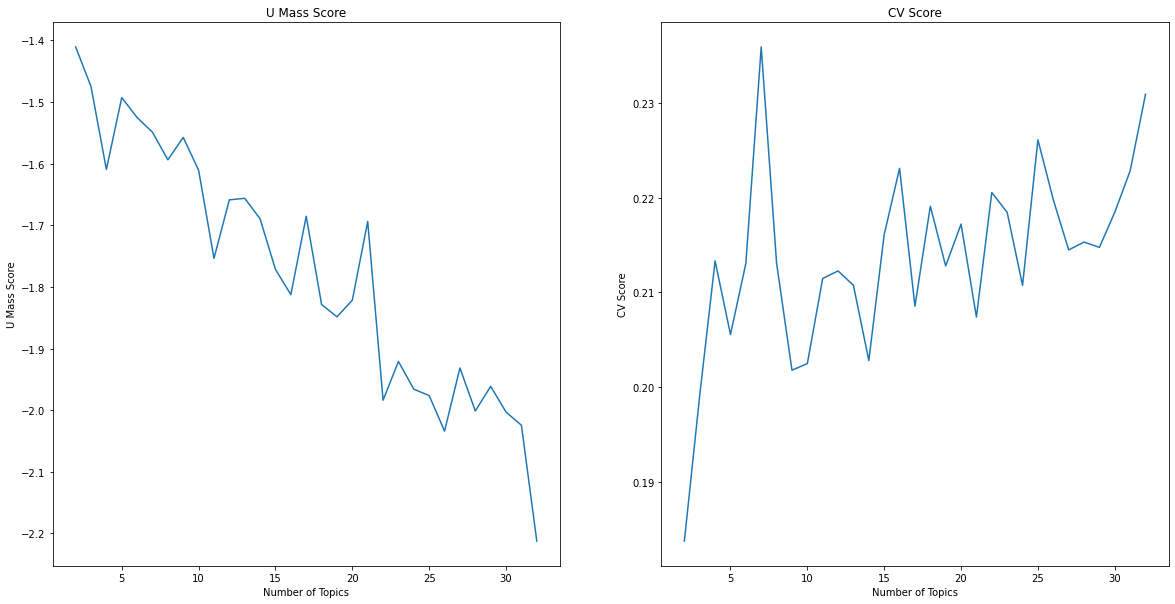

In [226]:
fig, axs= plt.subplots(ncols = 2, figsize=(20,10))

ax=axs[0]
ax.set_title('U Mass Score')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('U Mass Score')
ax.plot(numtop, coherence_umass)

ax=axs[1]
ax.set_title('CV Score')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('CV Score')
ax.plot(numtop, coherence_cv)

plt.show()

By looking at both scores, it appears that 7 is the ideal number of topics. This is the case as a global maximum is found in the CV score and, at the same time, also the U Mass score is quite high at this quantity. In previous analyses I had considererd also 25 topics but I noticed that multiple topics generated had no significant meaning and they demonstrated a lot of overlap with one another (seen through the pyLDAvis representation). Therefore, I deem 7 as a good number to capture the relevant topics.

In [227]:
topics=7
passes = 30 #I am increasing the overall passes to ensure greater accuracy in the topics
chunk = 1000 #I am analyzing 1000 books at the time

model = LdaMulticore(num_topics=topics, 
                     corpus=model_corpus,  
                     id2word=dictionary, 
                     passes=passes, 
                     chunksize=chunk, 
                     alpha=0.5, #I do not have an a priori belief of the distribution of topics, therefore I am leaving 0.5 here
                     random_state=10,
                     iterations=30 #maximum number of iterations. When increased, the results do not really change and only running time increases.
                    )

In [235]:
#Cleaning the text of the topics
import re
topic_sep = re.compile("0\.[0-9]{3}\*") 
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=topics, num_words=13)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:13])) #I am keeping 13 words per topic
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "hoffman", "bryce", "quince", "dumpy", "hogg", "marjorie", "dick", "sam", "jim", "mike", "peter", "tom", "planet"
2 "indians", "fort", "tom", "dick", "sam", "ai", "skipper", "washington", "colonel", "jim", "trench", "negro", "lieutenant"
3 "buster", "montague", "dave", "nan", "laura", "bert", "polly", "colonel", "tom", "madame", "david", "ann", "lucy"
4 "lur", "bessie", "tom", "dick", "harry", "peter", "madame", "hal", "paul", "jack", "ai", "joe", "colonel"
5 "madame", "mr", "princess", "monsieur", "peter", "mrs", "colonel", "tom", "jack", "jane", "alice", "knight", "mademoiselle"
6 "malone", "andy", "patty", "eric", "tom", "mr", "peter", "colonel", "sonny", "jane", "alice", "joe", "christmas"
7 "footnote", "jesus", "christ", "p.", "rome", "emperor", "hath", "sidenote", "spiritual", "doctrine", "egypt", "empire", "pope"


<>:4: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \.
C:\Users\fabio\AppData\Local\Temp\ipykernel_2904\1035022375.py:4: DeprecationWarning: invalid escape sequence \.
  topic_sep = re.compile("0\.[0-9]{3}\*") # getting rid of useless formatting


In [245]:
# transform the data into topic distros
topic_corpus = model[model_corpus]
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(data.text_colloc))]
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros.head()

hoffman, bryce  indians, fort  buster, montague  lur, bessie  madame, mr  \
0        0.036815       0.041199          0.036815     0.036815    0.329322   
1        0.021154       0.026295          0.021154     0.021154    0.850787   
2        0.015579       0.030698          0.015579     0.015579    0.326343   
3        0.023887       0.029207          0.023886     0.023887    0.490305   
4        0.027746       0.028035          0.027746     0.027746    0.469407   

   malone, andy  footnote, jesus  
0      0.036815         0.482219  
1      0.021154         0.038300  
2      0.015579         0.580644  
3      0.023886         0.384942  
4      0.027746         0.391573

Representation based on genre given in the data

In [246]:
topic_distros['fiction'] = data['fiction']
topic_distros['non-fiction'] = data['non-fiction']
topic_distros['classics'] = data['classics']
topic_distros['historical'] = data['historical']
topic_distros['20th-century'] = data['20th-century']
topic_distros['historical-fiction'] = data['historical-fiction']
topic_distros['literature'] = data['literature']
topic_distros['romance'] = data['romance']
topic_distros['fantasy'] = data['fantasy']
topic_distros['adventure'] = data['adventure']

topic_distros.head()

hoffman, bryce  indians, fort  buster, montague  lur, bessie  madame, mr  \
0        0.036815       0.041199          0.036815     0.036815    0.329322   
1        0.021154       0.026295          0.021154     0.021154    0.850787   
2        0.015579       0.030698          0.015579     0.015579    0.326343   
3        0.023887       0.029207          0.023886     0.023887    0.490305   
4        0.027746       0.028035          0.027746     0.027746    0.469407   

   malone, andy  footnote, jesus  fiction  non-fiction  classics  historical  \
0      0.036815         0.482219        1            1         1           1   
1      0.021154         0.038300        1            0         1           0   
2      0.015579         0.580644        1            1         1           1   
3      0.023886         0.384942        0            0         0           0   
4      0.027746         0.391573        1            1         1           1   

   20th-century  historical-fiction  literature  romance  fantasy  adventure  
0             0                   0           1        0        0          0  
1             1                   0           1        0        1          0  
2             1                   1           1        0        1          0  
3             1                   0           0        0        0          0  
4             1                   0           1        0        0          0

In [247]:
#I am averaging the scores based on genre. Note that if a book is part of more than 1 genre, it will be used in both genres.
fiction=topic_distros.groupby('fiction').mean().iloc[1 , :7]
non_fiction=topic_distros.groupby('non-fiction').mean().iloc[1 , :7]
classics=topic_distros.groupby('classics').mean().iloc[1 , :7]
historical=topic_distros.groupby('historical').mean().iloc[1 , :7]
century=topic_distros.groupby('20th-century').mean().iloc[1 , :7]
historical_fiction=topic_distros.groupby('historical-fiction').mean().iloc[1 , :7]
literature=topic_distros.groupby('literature').mean().iloc[1 , :7]
romance=topic_distros.groupby('romance').mean().iloc[1 , :7]
fantasy=topic_distros.groupby('fantasy').mean().iloc[1 , :7]
adventure=topic_distros.groupby('adventure').mean().iloc[1 , :7]

In [248]:
grap=pd.DataFrame({'fiction':fiction, 'non_fiction': non_fiction, 'classics': classics, 'historical':historical, 'century':century,
                  'historical-fiction':historical_fiction, 'literature':literature, 'romance':romance, 
                  'fantasy':fantasy, 'adventure':adventure}).reset_index()
grap

index   fiction  non_fiction  classics  historical   century  \
0    hoffman, bryce  0.035049     0.031377  0.034871    0.033583  0.033990   
1     indians, fort  0.089507     0.085398  0.081950    0.096616  0.075140   
2  buster, montague  0.035114     0.031289  0.034832    0.033678  0.033917   
3       lur, bessie  0.035111     0.031651  0.034789    0.033503  0.033969   
4        madame, mr  0.565796     0.478486  0.585716    0.541192  0.593450   
5      malone, andy  0.035090     0.031481  0.034890    0.033594  0.034176   
6   footnote, jesus  0.204540     0.310504  0.192954    0.228104  0.195358   

   historical-fiction  literature   romance   fantasy  adventure  
0            0.035287    0.033924  0.034951  0.037245   0.035111  
1            0.096538    0.070914  0.080678  0.076153   0.114464  
2            0.035581    0.034290  0.034963  0.037361   0.035174  
3            0.035280    0.033900  0.034948  0.037305   0.035014  
4            0.604599    0.591469  0.620789  0.624053   0.616965  
5            0.035410    0.034034  0.035366  0.037746   0.035002  
6            0.157789    0.201980  0.158305  0.150137   0.128270

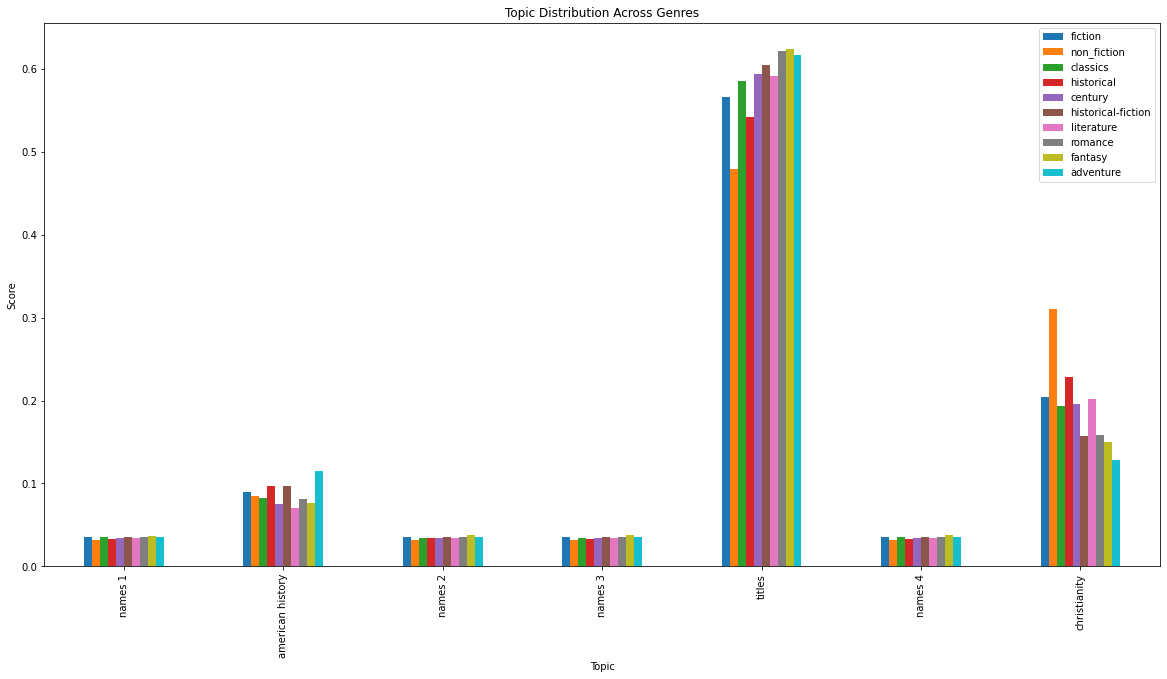

In [269]:
#Renaming the topics
grap.loc[0, 'index']='names 1'
grap.loc[1, 'index']='american history'
grap.loc[2, 'index']='names 2'
grap.loc[3, 'index']='names 3'
grap.loc[4, 'index']='titles'
grap.loc[5, 'index']='names 4'
grap.loc[6, 'index']='christianity'

#Plotting
fig, ax = plt.subplots(figsize=(20, 10))

grap.plot.bar(x = 'index', y = ['fiction', 'non_fiction', 'classics', 'historical', 'century', 'historical-fiction', 'literature',
                               'romance', 'fantasy', 'adventure'], ax=ax)
ax.set_title('Topic Distribution Across Genres')
ax.set_xlabel('Topic')
ax.set_ylabel('Score')

plt.show()

After this representation, it is impossible to observe significant differences in books of different genres. The only clearly distinguishable aspects are that non-fiction books have less frequency in terms of the use of old titles (i.e. princess, colonel,...) and a higher frequency in christianity. For the other genres, however, there are no significant differences. This motivates:
- Trying to represent each book graphically and look at the formation of clusters
- Using author models


In [261]:
df=topic_distros.drop(topic_distros.columns[[-2, -3, -4, -5, -6, -7, -8, -9, -10, -11]],axis = 1) #deleting the columns with binary values for genre
df=df.set_index('title')
df=df.fillna(0)
df['dominant_topic']=None
#Identifying the dominant topic per book
for i in range(len(df.dominant_topic)):
    df['dominant_topic'][i]=np.argmax(np.array(df.iloc[i, :-1]))

C:\Users\fabio\AppData\Local\Temp\ipykernel_2904\2609441718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dominant_topic'][i]=np.argmax(np.array(df.iloc[i, :-1]))


In [264]:
df=df.rename({'hoffman, bryce':'names 1', 'indians, fort':'american history', 'buster, montague':'names 2', 'lur, bessie':'names 3', 'madame, mr':'titles',
          'malone, andy':'names 4', 'footnote, jesus':'christianity'}, axis=1)
df.head()

names 1  american history   names 2   names 3  \
title                                                                         
apocolocyntosis              0.036815          0.041199  0.036815  0.036815   
the house on the borderland  0.021154          0.026295  0.021154  0.021154   
the warriors                 0.015579          0.030698  0.015579  0.015579   
a voyage to the moon         0.023887          0.029207  0.023886  0.023887   
la fiammetta                 0.027746          0.028035  0.027746  0.027746   

                               titles   names 4  christianity dominant_topic  
title                                                                         
apocolocyntosis              0.329322  0.036815      0.482219              6  
the house on the borderland  0.850787  0.021154      0.038300              4  
the warriors                 0.326343  0.015579      0.580644              6  
a voyage to the moon         0.490305  0.023886      0.384942              4  
la fiammetta                 0.469407  0.027746      0.391573              4

In [265]:
from sklearn.manifold import TSNE
tsne=TSNE(2, metric = 'cosine', random_state=2).fit_transform(df.iloc[:, :-1]) #I am excluding the column with the label

C:\Users\fabio\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [278]:
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=2, titles=None):
    fig = plt.figure(figsize=(20,20))
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    labels=np.array([f'Topic: {i}' for i in labels])
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    cm = plt.get_cmap('hsv') 
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
   
    if dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       label=label, 
                       alpha=0.4)
        books=[]
        label_seen=[]
        indexes=[]
        s=np.arange(0, len(df.label)-1)
        while len(books) != n_labels:
            a=np.random.choice(s, size=1)
            if labels[a] not in label_seen:
                books.append(titles[a])
                label_seen.append(labels[a])
                indexes.append(a)
        for h in range(len(indexes)):
            ind=indexes[h][0]
            x=vectors[:, 0][ind]
            y=vectors[:, 1][ind]
            ax.scatter(x, y, marker='*', s=200, color='r', edgecolor='k')
            ax.text(x+0.01, y+0.01, books[h][0], fontsize=15)    
    else:
        raise NotImplementedError()

    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, prop={'size': 15})
    plt.show()

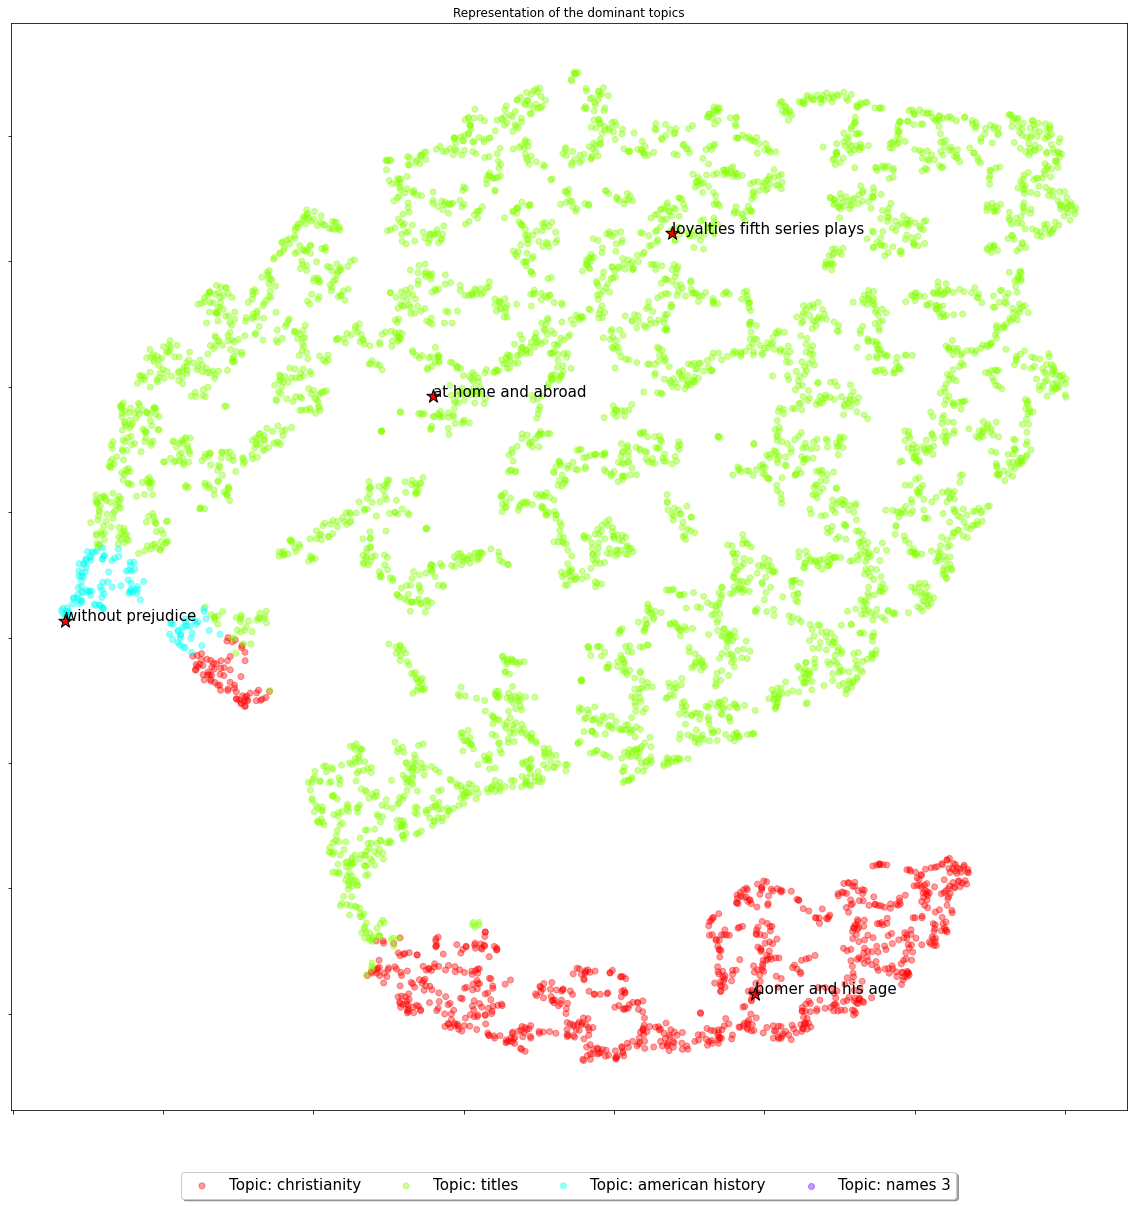

In [284]:
#Creating a match between dominant topic and its label
titles=np.array(df.index.tolist())
topics=np.array(df.columns)
labl=[topics[i] for i in df.iloc[:, -1]]
plot_vectors(tsne, 'Representation of the dominant topics', labl,2, titles)

From this graphical representation, it is possible to observe the presence of 4 dominant topics in the data set. For each topic, I have also reported the name of a book that is part of that topic. Overall, this represenation groups together books of different genre as the underlying dominant topics are common. It is worth noting how only 2 topics are useful in representing books: christianity and american history. The other topics tend to be too generic to be useful in characterizing the books.

In [268]:
#Representing how the topics are related to one another
#pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model, model_corpus, dictionary=dictionary)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.058500  0.122650       1        1  57.709599
6      0.183844 -0.041581       2        1  22.893812
1     -0.127774 -0.115815       3        1   8.047747
5      0.000588  0.008792       4        1   2.839071
0      0.000544  0.008602       5        1   2.837926
2      0.000624  0.008699       6        1   2.836424
3      0.000674  0.008654       7        1   2.835421, topic_info=         Term       Freq      Total Category  logprob  loglift
6653      tom  42.000000  42.000000  Default  30.0000  30.0000
6815     dick  31.000000  31.000000  Default  29.0000  29.0000
3548  indians  26.000000  26.000000  Default  28.0000  28.0000
7178       ai  27.000000  27.000000  Default  27.0000  27.0000
6232  colonel  36.000000  36.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
2040    jesus   0.094508  32.196272   Topic7 -10.0450  -2.2679
71       hath   0.094407  30.686704   Topic7 -10.0460  -2.2210
1535   christ   0.094340  32.364740   Topic7 -10.0467  -2.2749
2444  richard   0.094101  20.204082   Topic7 -10.0493  -1.8063
1648    david   0.093981  24.123454   Topic7 -10.0506  -1.9849

[493 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
2823       1  0.131419  00th
2823       2  0.525678  00th
2823       3  0.350452  00th
4608       2  0.935760  a.d.
19653      3  0.842476   aft
...      ...       ...   ...
2801       1  0.965686  wolf
9631       3  0.864443   wuz
8248       1  0.184713   yer
8248       3  0.738853   yer
23860      2  0.958164     §

[327 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 2, 6, 1, 3, 4])

###### Legend:
- Each bubble represents a topic. The larger the bubble, the higher percentage of books that are about that topic.
- Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
- Red bars give the estimated number of times a given term was generated by a given topic. 
- The further the bubbles are away from each other, the more different they are. 

Also, a topic can be characterized based on the bar grah on the right. In this regard:
- Bubble 1: Titles
- Bubble 2: Christianity
- Bubble 3: American History
- Bubble 4,5,6,7: Names

From this represenation, it possible to observe that, overall, 4 main topics are present in the dataset. This result is in line with the representation of the dominant topic for each book shown above. Moreover, it appears that there is 1 topic that dominates the entire dataset. Such topic corresponds to that of titles (in line with the bar chart presented above).
The main conclusion that ca be drawn from this LDA analysis is that such modelling is not able to capture granularities of different books and genres. This big limitation motivates the next section, which will focus on author topic modelling.

## Author topic model

In [133]:
from gensim.models import AuthorTopicModel
from collections import defaultdict
genre2doc = defaultdict(list) # mapping from genre to document

for i in range(len(data.fiction)):
    if data.fiction[i]==1:
        genre2doc['fiction'].append(i) # I am appending the index of the book that is considered as fiction. Once again, if a book is part of more than 1
                                       # genre, I will consider it in both genres.
        
for i in range(len(data.fiction)):
    if data.classics[i]==1:
        genre2doc['classics'].append(i)
        
for i in range(len(data.fiction)):
    if data.historical[i]==1:
        genre2doc['historical'].append(i)
        
for i in range(len(data.fiction)):
    if data['20th-century'][i]==1:
        genre2doc['20th-century'].append(i)
        
for i in range(len(data.fiction)):
    if data['non-fiction'][i]==1:
        genre2doc['non-fiction'].append(i)
        
for i in range(len(data.fiction)):
    if data['historical-fiction'][i]==1:
        genre2doc['historical-fiction'].append(i)
        
for i in range(len(data.fiction)):
    if data.literature[i]==1:
        genre2doc['literature'].append(i)
        
for i in range(len(data.fiction)):
    if data.romance[i]==1:
        genre2doc['romance'].append(i)
        
for i in range(len(data.fiction)):
    if data.fantasy[i]==1:
        genre2doc['fantasy'].append(i)
        
for i in range(len(data.fiction)):
    if data.adventure[i]==1:
        genre2doc['adventure'].append(i)

len(genre2doc)

10

In [134]:
coherence_values = []
umass=[]
cv=[]
ntop=[]

#I am training the model on all the books in the dataset
for num_topics in range(2, 33): 
    author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                    author2doc=genre2doc, 
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    alpha=0.5, #I have no a priori knowedge about the distribution of the different topics
                                    random_state=42
                                   )
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=words_perbook, 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=words_perbook, 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    ntop.append(num_topics)
    umass.append(umass_score)
    cv.append(cv_score)

2 -1.2229931340567752 0.29284606826061876
3 -1.30237424925021 0.27400699604675954
4 -1.3011237828150533 0.27515027587060764
5 -1.2518994264847823 0.29607960182247994
6 -1.2961739530211396 0.3181464438816746
7 -1.37117629772615 0.31510135609027007
8 -1.4084408265790607 0.3080630577305782
9 -1.543775827759939 0.31210710856383794
10 -1.5697797180950115 0.3015679408102273
11 -1.5069782837321901 0.3522970822474202
12 -1.5027448516389166 0.34168062003096217
13 -1.4964304399246893 0.334547104562617
14 -1.608113073301583 0.34564750860347837
15 -1.6629303082080924 0.3411885996228925
16 -1.7154762733612432 0.351649527642967
17 -1.7811707881476082 0.35262458586074746
18 -1.805576899800985 0.3506402352007047
19 -1.761200307712768 0.33363519784405504
20 -1.7716869759463307 0.33919037975564753
21 -1.705660245287873 0.35313106819931717
22 -1.793583656973019 0.35161884515693165
23 -1.6934464719325286 0.35344843176553986
24 -1.7081338161403272 0.35734348663523036
25 -1.7338214444707254 0.34963909688412

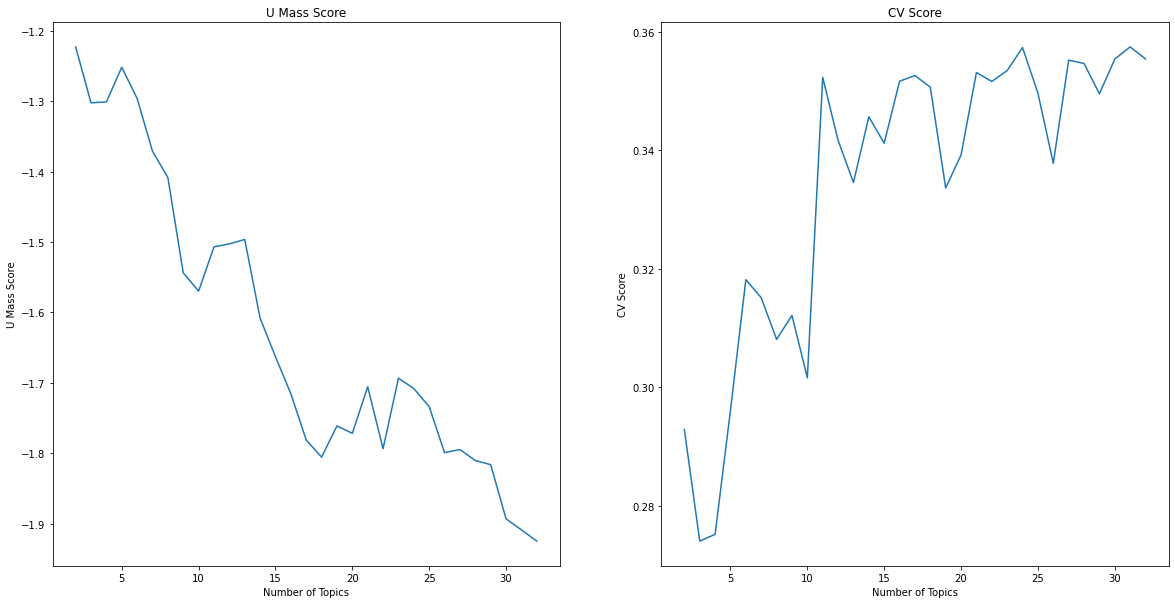

In [136]:
fig, axs= plt.subplots(ncols = 2, figsize=(20,10))

ax=axs[0]
ax.set_title('U Mass Score')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('U Mass Score')
ax.plot(ntop, umass)

ax=axs[1]
ax.set_title('CV Score')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('CV Score')
ax.plot(ntop, cv)

plt.show()

It appears that there is a local maximum in both graphs at around 11 topics. I am selecting 11 as I am attributing importance to coherence values. Additionally, the peak observed at 11 for CV is, almost, a global maximum in the CV score graph. Finally, it is worth noting that the CV score with author topic modelling is much higher than that of LDA. This indicated that the topics identified have a greater coherence and can, thus, better describe the books in the dataset.

In [137]:
n_topics_author = 11
num_passes=30 #I am iterating 30 times over the training data
chunk_size=1000 #I am considering 1000 books at the time
author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                author2doc=genre2doc, 
                                id2word=dictionary, 
                                num_topics=n_topics_author,
                                passes=num_passes,
                                chunksize=chunk_size,
                                alpha=0.5,
                                random_state=42
)

In [138]:
#Cleaning the topics
import re
topic_sep = re.compile("0\.[0-9]{3}\*")
author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=10)]

author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:10]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "madame", "monsieur", "mrs", "mr", "philip", "t", "squire", "anne", "mademoiselle", "papa"
2 "00th", "emperor", "rome", "duke", "fleet", "spanish", "empire", "italy", "footnote", "governor"
3 "president", "footnote", "irish", "negro", "ireland", "vote", "slavery", "constitution", "community", "p."
4 "knight", "princess", "arthur", "hath", "slay", "hast", "robin", "earl", "thine", "yonder"
5 "don", "mr", "poem", "roland", "literary", "duke", "humour", "shakespeare", "alice", "favourite"
6 "specie", "butter", "scientific", "p.", "organ", "bee", "fig", "s.", "c.", "player"
7 "tom", "ruth", "helen", "dick", "jim", "peter", "colonel", "ellen", "harry", "sam"
8 "ai", "jane", "billy", "bob", "joe", "betty", "maggie", "tommy", "goin'", "laura"
9 "tom", "jack", "dick", "mr", "mate", "crew", "kennedy", "professor", "cabin", "david"
10 "christ", "jesus", "hath", "paul", "peter", "et", "egypt", "moses", "que", "spiritual"
11 "indians", "hunter", "fort", "tent", "canoe", "log", "rifle", "cabin", 

<>:2: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \.
C:\Users\fabio\AppData\Local\Temp\ipykernel_2904\787259661.py:2: DeprecationWarning: invalid escape sequence \.
  topic_sep = re.compile("0\.[0-9]{3}\*")


In [139]:
# initialize mapping from genre to topic distro, set all to 0.0
genre_vecs = {genre: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for genre in author_model.id2author.values()
              }
# update mappings from model
for genre in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(genre):
        genre_vecs[genre][author_descriptors[t]] = v

In [143]:
genre_gr=pd.DataFrame.from_dict(genre_vecs).reset_index()
genre_gr.head()

index  20th-century  adventure  classics   fantasy   fiction  \
0     madame, monsieur      0.120796   0.012039  0.194738  0.000000  0.151616   
1        00th, emperor      0.000000   0.018582  0.032763  0.000000  0.000000   
2  president, footnote      0.130497   0.000000  0.062538  0.000000  0.031636   
3     knight, princess      0.051025   0.015461  0.216013  0.826363  0.038934   
4              don, mr      0.113712   0.000000  0.032155  0.000000  0.000000   

   historical  historical-fiction  literature  non-fiction   romance  
0    0.054838            0.190026    0.000000     0.000000  0.449275  
1    0.054097            0.000000    0.000000     0.000000  0.072930  
2    0.027777            0.000000    0.000000     0.094281  0.208444  
3    0.140421            0.389363    0.430958     0.000000  0.095152  
4    0.000000            0.000000    0.326696     0.000000  0.000000

In [144]:
#Renaming the different topics
genre_gr.loc[0, 'index'] = 'court titles'
genre_gr.loc[1,'index'] = 'politics'
genre_gr.loc[2,'index'] = 'anti-slavery'
genre_gr.loc[3,'index'] = 'medieval times'
genre_gr.loc[4,'index'] = 'poems'
genre_gr.loc[5,'index'] = 'animals'
genre_gr.loc[6,'index'] = 'names'
genre_gr.loc[7,'index'] = 'old names'
genre_gr.loc[8,'index'] = 'voyage'
genre_gr.loc[9,'index'] = 'christianity'
genre_gr.loc[10,'index'] = 'wild-west'

In [145]:
genre_gr.head()

index  20th-century  adventure  classics   fantasy   fiction  \
0    court titles      0.120796   0.012039  0.194738  0.000000  0.151616   
1        politics      0.000000   0.018582  0.032763  0.000000  0.000000   
2    anti-slavery      0.130497   0.000000  0.062538  0.000000  0.031636   
3  medieval times      0.051025   0.015461  0.216013  0.826363  0.038934   
4           poems      0.113712   0.000000  0.032155  0.000000  0.000000   

   historical  historical-fiction  literature  non-fiction   romance  
0    0.054838            0.190026    0.000000     0.000000  0.449275  
1    0.054097            0.000000    0.000000     0.000000  0.072930  
2    0.027777            0.000000    0.000000     0.094281  0.208444  
3    0.140421            0.389363    0.430958     0.000000  0.095152  
4    0.000000            0.000000    0.326696     0.000000  0.000000

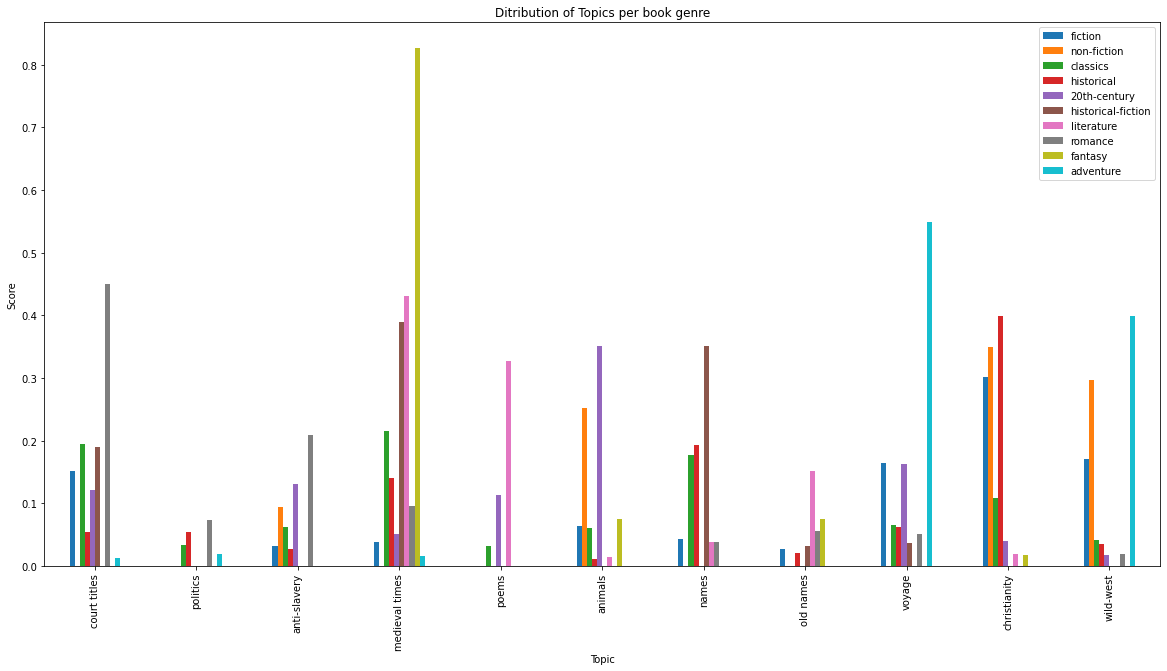

In [224]:
fig, ax = plt.subplots(figsize=(20, 10))

genre_gr.plot.bar(x = 'index', y = ['fiction', 'non-fiction', 'classics', 'historical', '20th-century', 'historical-fiction', 'literature',
                               'romance', 'fantasy', 'adventure'], ax=ax)
ax.set_title('Ditribution of Topics per book genre')
ax.set_ylabel('Score')
ax.set_xlabel('Topic')

plt.show()

From this graphical representation it is possible to clearly distinguish genres based on the topic that they are about. In fact, basically for every topic identified there is a dominant genre. Overall, the different observed topics are in line with the expectations that we can form about the different genres.

In [154]:
#Determining the Dominant topic for each genre
df1=genre_gr
df1=df1.set_index('index')
df1=df1.T
df1['dominant_topic']=None
df1=df1.fillna(0)
for i in range(len(df1.dominant_topic)):
    df1['dominant_topic'][i]=np.argmax(np.array(df1.iloc[i, :]))

C:\Users\fabio\AppData\Local\Temp\ipykernel_2904\101800321.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dominant_topic'][i]=np.argmax(np.array(df1.iloc[i, :]))


In [288]:
from sklearn.manifold import TSNE
tsne=TSNE(2, metric = 'cosine', random_state=2).fit_transform(df1.iloc[:, :-1])

C:\Users\fabio\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [291]:
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_topics(vectors, title='VIZ', labels=None, dimensions=2, titles=None):
    fig = plt.figure(figsize=(10,10))
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1], 'genre':titles})
    labels=np.array([f'Topic: {i}' for i in labels])
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    cm = plt.get_cmap('hsv') 
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
   
    if dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, s=50,
                       cmap=cMap, 
                       label=label, 
                       alpha=0.4)
        for i in range(len(df.x)):
            ax.text(df['x'][i], df['y'][i], titles[i], fontsize=13)
    else:
        raise NotImplementedError()

    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, prop={'size': 15})
    plt.show()

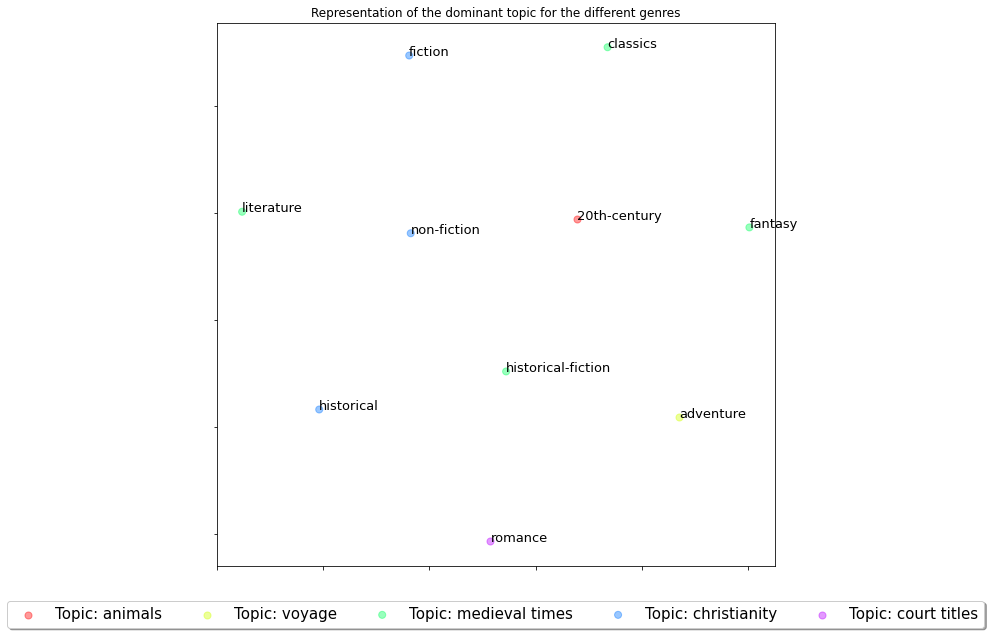

In [292]:
b=df1.columns.tolist() #Topic names
a=df1.iloc[:, -1].tolist() #Dominant topics per each genre
c=[b[i] for i in a] #Mapping topic name to dominant topic per each genre
genres=np.array(df1.index)
plot_topics(tsne, 'Representation of the dominant topic for the different genres', c,2, genres)

The representation of the dominant topic for each book genre highlights similarities between them. In particular, topics related to christianity are addressed in historical, non-fiction and fiction books reported in the dataset. Moreover, medieval times are addressed by literature, classics, fantasy and historical-fiction as expected. Additionally, it is possible to observe that the remaining topics are dominant only in books of different genres. In fact, voyages topics are addressed by adventure books, court titles in romance books and, finally, animal topics are addressed in 20th century books.

Finally, it is possible to exploit the books corpuses to predict the genre of an unseen book. To achieve this goal: Language Models

### Language Models
I will be creating language models for each genre (considering only books that have 1 genre) and then I will combine this information to predict, through perplexity, the top 2 genre for the new input in the model.

In [55]:
import pandas as pd
df=pd.read_csv('Definite_data.csv')
#I am using the uncleaned data so that stopwords will be present and also, the text that will be fed into the model will not be cleaned.

In [3]:
import re
def reformatGenres(genres):
    l_genres = list(filter(None, re.split(r"[\{\}\,\s\']", genres)))
    # Combine history and historical tags since they refer to the same genre
    r_genres = list({e if e!='history' else 'historical' for e in l_genres})
    return r_genres
df.genres = df.loc[:, 'genres'].apply(reformatGenres)

#Fixing the parentheses in genre
for j in range(len(df.genres)):
    a=''
    for h in df.loc[j, 'genres']:
        a+=h+' '
    df.loc[j, 'genres']=a
    df.loc[j, 'genres']=df.loc[j, 'genres'].replace(']','')
    df.loc[j, 'genres']=df.loc[j, 'genres'].replace('[','')
    
#Reformatting genre in a more clear manner
for j in range(len(df.genres)):    
    l=df.genres[j].replace('\'', '').split(',')
    g=[]
    for i in l:
        if len(i)>2:
            g.append(i)
    df.loc[j, 'genres']=' '.join(g)
    
df.head()

Unnamed: 0                        Title                author  year  \
0           0              apocolocyntosis                Seneca    54   
1           1  the house on the borderland  William Hope Hodgson  1908   
2           2                 the warriors            Sol Yurick  1965   
3           3         a voyage to the moon         George Tucker  1827   
4           4                 la fiammetta    Giovanni Boccaccio  1343   

                                                text  \
0  Produced by Ted Garvin, Ben Courtney and PG Di...   
1  Produced by Suzanne Shell, Sjaani and PG Distr...   
2  Produced by Charles Aldarondo, Charlie Kirschn...   
3  Produced by Christine De Ryck, Stig M. Valstad...   
4  Produced by Ted Garvin, Dave Morgan and PG Dis...   

                                              genres  
0  classics non-fiction fiction   literature hist...  
1  classics fiction fantasy   literature 20th-cen...  
2  classics non-fiction fiction historical-fictio...  
3                                       20th-century  
4  classics non-fiction fiction   literature 20th...

In [8]:
from collections import defaultdict, Counter
import numpy as np
import nltk

smoothing = 0.0001 #smoothing parameter
START = '_***_'
STOP = '_STOP_'

counts_classics = defaultdict(lambda: defaultdict(lambda: smoothing))

classic_books=df[df['genres']=='classics']
words_perbook = classic_books['text'].apply(str.split).tolist()

for sentence in words_perbook:
    tokens = [START] + sentence + [STOP]
    for u, v in nltk.ngrams(tokens, 2): #to avoid memory errors I am looking at bigrams
        counts_classics[u][v] += 1

def logP_classics(u, w):
    return np.log(counts_classics[u][w]) - np.log(sum(counts_classics[u].values()))

def sentence_classics(S):
    tokens = [START] + S + [STOP]
    return sum([logP_classics(u, v) for u, v in nltk.ngrams(tokens, 2)])

In [9]:
counts_adventure = defaultdict(lambda: defaultdict(lambda: smoothing))

adventure_books=df[df['genres']=='adventure']
words_perbook = adventure_books['text'].apply(str.split).tolist()

for sentence in words_perbook:
    tokens = [START] + sentence + [STOP]
    for u, v in nltk.ngrams(tokens, 2): #to avoid memory errors I am looking at bigrams
        counts_adventure[u][v] += 1

def logP_adventure(u, w):
    return np.log(counts_adventure[u][w]) - np.log(sum(counts_adventure[u].values()))

def sentence_adventure(S):
    tokens = [START] + S + [STOP]
    return sum([logP_adventure(u, v) for u, v in nltk.ngrams(tokens, 2)])

In [10]:
counts_literature = defaultdict(lambda: defaultdict(lambda: smoothing))

literature_books=df[df['genres']=='literature']
words_perbook = literature_books['text'].apply(str.split).tolist()

for sentence in words_perbook:
    tokens = [START] + sentence + [STOP]
    for u, v in nltk.ngrams(tokens, 2): #to avoid memory errors I am looking at bigrams
        counts_literature[u][v] += 1

def logP_literature(u, w):
    return np.log(counts_literature[u][w]) - np.log(sum(counts_literature[u].values()))

def sentence_literature(S):
    tokens = [START] + S + [STOP]
    return sum([logP_literature(u, v) for u, v in nltk.ngrams(tokens, 2)])

In [11]:
counts_fantasy = defaultdict(lambda: defaultdict(lambda: smoothing))

fantasy_books=df[df['genres']=='fantasy']
words_perbook = fantasy_books['text'].apply(str.split).tolist()

for sentence in words_perbook:
    tokens = [START] + sentence + [STOP]
    for u, v in nltk.ngrams(tokens, 2): #to avoid memory errors I am looking at bigrams
        counts_fantasy[u][v] += 1

def logP_fantasy(u, w):
    return np.log(counts_fantasy[u][w]) - np.log(sum(counts_fantasy[u].values()))

def sentence_fantasy(S):
    tokens = [START] + S + [STOP]
    return sum([logP_fantasy(u, v) for u, v in nltk.ngrams(tokens, 2)])

In [12]:
counts_historical = defaultdict(lambda: defaultdict(lambda: smoothing))

historical_books=df[df['genres']=='historical']
words_perbook = historical_books['text'].apply(str.split).tolist()

for sentence in words_perbook:
    tokens = [START] + sentence + [STOP]
    for u, v in nltk.ngrams(tokens, 2): #to avoid memory errors I am looking at bigrams
        counts_historical[u][v] += 1

def logP_historical(u, w):
    return np.log(counts_historical[u][w]) - np.log(sum(counts_historical[u].values()))

def sentence_historical(S):
    tokens = [START] + S + [STOP]
    return sum([logP_historical(u, v) for u, v in nltk.ngrams(tokens, 2)])

In [13]:
counts_romance = defaultdict(lambda: defaultdict(lambda: smoothing))

romance_books=df[df['genres']=='romance']
words_perbook = romance_books['text'].apply(str.split).tolist()

for sentence in words_perbook:
    tokens = [START] + sentence + [STOP]
    for u, v in nltk.ngrams(tokens, 2): #to avoid memory errors I am looking at bigrams
        counts_romance[u][v] += 1

def logP_romance(u, w):
    return np.log(counts_romance[u][w]) - np.log(sum(counts_romance[u].values()))

def sentence_romance(S):
    tokens = [START] + S + [STOP]
    return sum([logP_romance(u, v) for u, v in nltk.ngrams(tokens, 2)])

In [14]:
counts_fiction = defaultdict(lambda: defaultdict(lambda: smoothing))

fiction_books=df[df['genres']=='fiction']
words_perbook = fiction_books['text'].apply(str.split).tolist()

for sentence in words_perbook:
    tokens = [START] + sentence + [STOP]
    for u, v in nltk.ngrams(tokens, 2): #to avoid memory errors I am looking at bigrams
        counts_fiction[u][v] += 1

def logP_fiction(u, w):
    return np.log(counts_fiction[u][w]) - np.log(sum(counts_fiction[u].values()))

def sentence_fiction(S):
    tokens = [START] + S + [STOP]
    return sum([logP_fiction(u, v) for u, v in nltk.ngrams(tokens, 2)])

In [15]:
counts_century = defaultdict(lambda: defaultdict(lambda: smoothing))

century_books=df[df['genres']=='20th-century']
words_perbook = century_books['text'].apply(str.split).tolist()

for sentence in words_perbook:
    tokens = [START] + sentence + [STOP]
    for u, v in nltk.ngrams(tokens, 2): #to avoid memory errors I am looking at bigrams
        counts_century[u][v] += 1

def logP_century(u, w):
    return np.log(counts_century[u][w]) - np.log(sum(counts_century[u].values()))

def sentence_century(S):
    tokens = [START] + S + [STOP]
    return sum([logP_century(u, v) for u, v in nltk.ngrams(tokens, 2)])

In [16]:
import numpy as np
from collections import Counter

def genre_predictor(text):
    literature=[]
    fantasy=[]
    adventure=[]
    historical=[]
    romance=[]
    fiction=[]
    century=[]
    classics=[]
    for i in text:
        literature.append(2**-sentence_literature(i))
        fantasy.append(2**-sentence_fantasy(i))
        adventure.append(2**-sentence_adventure(i))
        historical.append(2**-sentence_historical(i))
        romance.append(2**-sentence_romance(i))
        fiction.append(2**-sentence_fiction(i))
        century.append(2**-sentence_century(i))
        classics.append(2**-sentence_classics(i))
    
    d={'literature':np.mean(literature), 'fantasy':np.mean(fantasy), 'adventure':np.mean(adventure), 'historical':np.mean(historical),
      'romance':np.mean(romance), 'fiction':np.mean(fiction), 'century':np.mean(century), 'classics':np.mean(classics)}
    top=Counter(d).most_common()[:-3:-1]
    l=[top[0][0], top[1][0]]
    return 'The predicted genres are: '+', '.join(l)

In [58]:
df[df['Title']=='moby dick'] #the model is blind to Moby Dick

Empty DataFrame
Columns: [Unnamed: 0, Title, author, year, text, genres]
Index: []

In [30]:
test = [line.strip().split() for line in open('moby_dick.txt')]
genre_predictor(test[5:50])
#The model seems to predict the correct genre for Moby Dick

'The predicted genres are: adventure, fantasy'

## Conclusion
This notebook seeked to identify the similarities and differences that are present between books of different genres. In most of the analyses, the common result that was observed was that genres were not a relevant feature in clustering books together. Rather, the actual content of the book revealed similarities that span across genres, as, books of different genre talk about similar topics. Only through author topic modelling it was possible to observe that the book genre was a good classifier as relevant and logical differences between the books were obsereved. In conclusion, for the construction of a book recommender system, it appears that suggestions should be made by comparing the content of the books and not simply their genre. The result of the above analysis have to be interpreted with care for 2 different reasons:
- The dataset contains books that are quite far apart from one another in terms of publication year. An improvement that could be introduced would be that of analyzing books of similar time periods together.
- The dataset can still be considered small as, overall, only 5713 books were analyzed. Moreover, only half of each book was considered due to extremely long processing time.

Other avenues of exploratory analyses in this domain could relate to the study of how topics change across the decades and comparing different authors with one another.